## Import Library

In [1]:
import torch
import kagglehub
import numpy as np
import pandas as pd
import os, shutil, random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from torch import nn
from PIL import Image
from tqdm import tqdm
from pathlib import Path
from sklearn.cluster import KMeans
import torchvision.transforms as T
import torchvision.models as models
from scipy.optimize import lsq_linear
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.model_selection import StratifiedKFold

## Load Dataset

In [2]:
# XRAY DATASET
path_xray = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")
print("Path to dataset files:", path_xray)

Using Colab cache for faster access to the 'chest-xray-pneumonia' dataset.
Path to dataset files: /kaggle/input/chest-xray-pneumonia


In [3]:
# CT-Scan DATASET
path_ct = kagglehub.dataset_download("akash10rout/pneumonia-balanced-ct")
print("Path to dataset files:", path_ct)

100%|██████████| 573M/573M [00:06<00:00, 89.8MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/akash10rout/pneumonia-balanced-ct/versions/1


In [4]:
# Source paths for both datasets
src1 = path_xray
src2 = path_ct

# Define the destination directory
dst = '/content/combined_dataset'

# Create the destination directory if it doesn't exist
if not os.path.exists(dst):
    os.makedirs(dst)

# Function to copy contents of a directory
def copy_directory_contents(src_dir, dst_dir):
    for item in os.listdir(src_dir):
        s = os.path.join(src_dir, item)
        d = os.path.join(dst_dir, item)
        if os.path.isdir(s):
            shutil.copytree(s, d, symlinks=False, ignore=None, copy_function=shutil.copy2, ignore_dangling_symlinks=False, dirs_exist_ok=True)
        else:
            shutil.copy2(s, d)

# Copy contents of the first dataset
copy_directory_contents(src1, dst)

# Copy contents of the second dataset
copy_directory_contents(src2, dst)

print(f"Contents of both datasets copied to: {dst}")

Contents of both datasets copied to: /content/combined_dataset


In [5]:
penumonia_xray = os.path.join(dst, 'pneumonia_xray')
# Construct the full paths for the new directories
normal_dir = os.path.join(penumonia_xray, 'Normal')
pneumonia_dir = os.path.join(penumonia_xray, 'Pneumonia')

# Create the new directories
os.makedirs(normal_dir, exist_ok=True)
os.makedirs(pneumonia_dir, exist_ok=True)
os.makedirs(penumonia_xray, exist_ok=True)

print(f"Created directories: {normal_dir} and {pneumonia_dir}")

Created directories: /content/combined_dataset/pneumonia_xray/Normal and /content/combined_dataset/pneumonia_xray/Pneumonia


In [6]:
normal_image_paths = []
pneumonia_image_paths = []

# Define the paths for the datasets
dataset_xray = "/content/combined_dataset/chest_xray/chest_xray"

# Iterate through the directory structure of dataset_xray
for root, dirs, files in os.walk(dataset_xray):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(root, file)
            if 'NORMAL' in root:
                normal_image_paths.append(file_path)
            elif 'PNEUMONIA' in root:
                pneumonia_image_paths.append(file_path)

print(f"Number of normal image paths found: {len(normal_image_paths)}")
print(f"Number of pneumonia image paths found: {len(pneumonia_image_paths)}")

Number of normal image paths found: 1583
Number of pneumonia image paths found: 4273


In [7]:
# Copy normal images
for img_path in normal_image_paths:
    base_filename = os.path.basename(img_path)
    dest_path = os.path.join(normal_dir, base_filename)
    shutil.copy2(img_path, dest_path)

# Copy pneumonia images
for img_path in pneumonia_image_paths:
    base_filename = os.path.basename(img_path)
    dest_path = os.path.join(pneumonia_dir, base_filename)
    shutil.copy2(img_path, dest_path)

print("Image copying process completed for both normal and pneumonia categories.")

Image copying process completed for both normal and pneumonia categories.


In [8]:
# List files in the new directories
normal_files = os.listdir(normal_dir)
pneumonia_files = os.listdir(pneumonia_dir)

# Print the number of files found
print(f"Number of files in {normal_dir}: {len(normal_files)}")
print(f"Number of files in {pneumonia_dir}: {len(pneumonia_files)}")

# Compare with the number of image paths identified earlier
print(f"Number of normal image paths identified: {len(normal_image_paths)}")
print(f"Number of pneumonia image paths identified: {len(pneumonia_image_paths)}")

# Optionally, print the first few filenames from each directory
print("\nFirst 5 filenames in normal directory:")
for i in range(min(5, len(normal_files))):
    print(normal_files[i])

print("\nFirst 5 filenames in pneumonia directory:")
for i in range(min(5, len(pneumonia_files))):
    print(pneumonia_files[i])

Number of files in /content/combined_dataset/pneumonia_xray/Normal: 1583
Number of files in /content/combined_dataset/pneumonia_xray/Pneumonia: 4273
Number of normal image paths identified: 1583
Number of pneumonia image paths identified: 4273

First 5 filenames in normal directory:
NORMAL2-IM-0867-0001.jpeg
NORMAL2-IM-0654-0001.jpeg
NORMAL2-IM-0899-0001.jpeg
IM-0369-0001.jpeg
NORMAL2-IM-0806-0001.jpeg

First 5 filenames in pneumonia directory:
person141_virus_287.jpeg
person1658_bacteria_4402.jpeg
person1345_bacteria_3428.jpeg
person379_virus_762.jpeg
person846_virus_1491.jpeg


In [9]:
# Xray Dataset Variable
dataset_xray = "/content/combined_dataset/pneumonia_xray"

In [10]:
# CT-Scan Dataset Variable
dataset_ct = "/content/combined_dataset/Pneumonia Balanced CT"

## Data Preprocessing

In [11]:
# Set maximum images per class (will be applied via sampling, NOT deletion)
MAX_IMAGES_PER_CLASS = 1550

In [12]:
dataset_xray_path = Path(dataset_xray)
pneumonia_xray_dir = dataset_xray_path / "Pneumonia"
normal_xray_dir = dataset_xray_path / "Normal"

image_paths = []
labels = []

# Support multiple image extensions (jpeg, jpg, png)
image_extensions = ["*.jpeg", "*.jpg", "*.png"]

for ext in image_extensions:
    for img_path in pneumonia_xray_dir.glob(ext):
        image_paths.append(str(img_path))
        labels.append("Pneumonia")

for ext in image_extensions:
    for img_path in normal_xray_dir.glob(ext):
        image_paths.append(str(img_path))
        labels.append("Normal")

df_xray = pd.DataFrame({
    "filepath": image_paths,
    "label": labels,
})

# Sample to MAX_IMAGES_PER_CLASS per class )
print("Data before sampling:")
print(df_xray["label"].value_counts())

df_xray = df_xray.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(MAX_IMAGES_PER_CLASS, len(x)), random_state=42)
).reset_index(drop=True)

# Map labels to indices
label_mapping = {"Normal": 0, "Pneumonia": 1}
df_xray["label_idx"] = df_xray["label"].map(label_mapping)

print("Total data (after sampling):", len(df_xray))
print(df_xray["label"].value_counts())

Data before sampling:
label
Pneumonia    4273
Normal       1583
Name: count, dtype: int64
Total data (after sampling): 3100
label
Normal       1550
Pneumonia    1550
Name: count, dtype: int64


/tmp/ipython-input-266229640.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_xray = df_xray.groupby('label', group_keys=False).apply(


In [13]:
dataset_ct_path = Path(dataset_ct)
pneumonia_ct_dir = dataset_ct_path / "Pneumonia"
normal_ct_dir = dataset_ct_path / "Normal"

image_paths = []
labels = []

# Support multiple image extensions (png, jpg, jpeg)
image_extensions = ["*.png", "*.jpg", "*.jpeg"]

for ext in image_extensions:
    for img_path in pneumonia_ct_dir.glob(ext):
        image_paths.append(str(img_path))
        labels.append("Pneumonia")

for ext in image_extensions:
    for img_path in normal_ct_dir.glob(ext):
        image_paths.append(str(img_path))
        labels.append("Normal")

df_ct = pd.DataFrame({
    "filepath": image_paths,
    "label": labels,
})

# Sample to MAX_IMAGES_PER_CLASS per class (non-destructive)
print("Data before sampling:")
print(df_ct["label"].value_counts())

df_ct = df_ct.groupby('label', group_keys=False).apply(
    lambda x: x.sample(n=min(MAX_IMAGES_PER_CLASS, len(x)), random_state=42)
).reset_index(drop=True)

# Map labels to indices
label_mapping = {"Normal": 0, "Pneumonia": 1}
df_ct["label_idx"] = df_ct["label"].map(label_mapping)

print("Total data (after sampling):", len(df_ct))
print(df_ct["label"].value_counts())

Data before sampling:
label
Pneumonia    2618
Normal       2618
Name: count, dtype: int64
Total data (after sampling): 3100
label
Normal       1550
Pneumonia    1550
Name: count, dtype: int64


/tmp/ipython-input-196145817.py:30: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_ct = df_ct.groupby('label', group_keys=False).apply(


# Data Splitting

## Data Splitting XRAY

In [14]:
## NOT BEING USED

# # # Splitting data X-Ray into two different subset [sub 1 and sub 2] (0.5 each)
# # sub1_xray_df, sub2_xray_df = train_test_split(
# #     df_xray,
# #     test_size=0.2,
# #     stratify=df_xray["label_idx"],
# #     random_state=42,
# # )

# # print("\nSubset Size:")
# # print("Sub1:", len(sub1_xray_df))
# # print("Sub2:", len(sub2_xray_df))

# # print("\nLabel Distribution Sub1:")
# # print(sub1_xray_df["label"].value_counts(normalize=True))

# # print("\nLabel Distribution Sub2:")
# # print(sub2_xray_df["label"].value_counts(normalize=True))

# # Splitting data X-Ray into two different subset [sub 1 and sub 2] (80%)
# # WE DONT NEED THIS!!
# sub1_xray_df = train_test_split(
#     df_xray,
#     test_size=0.2,
#     stratify=df_xray["label_idx"],
#     random_state=42,
# )

# print("\nSubset Size:")
# print("Sub1:", len(sub1_xray_df))

# print("\nLabel Distribution Sub1:")
# print(sub1_xray_df["label"].value_counts(normalize=True))

In [15]:
# Split Sub1 -> Train (80% from Sub1) and temp (20% from Sub1)
train_xray_df, temp_xray_df = train_test_split(
    df_xray,
    test_size=0.2,
    stratify=df_xray["label_idx"],
    random_state=42,
)

# Split sub temp -> val (50% temp) and test (50% temp)
val_xray_df, test_xray_df = train_test_split(
    temp_xray_df,
    test_size=0.5,
    stratify=temp_xray_df["label_idx"],
    random_state=42,
)

print("\nSubsets Size for X-Ray:")
print("Train:", len(train_xray_df))
print("Val  :", len(val_xray_df))
print("Test :", len(test_xray_df))

print("\nLabel Distribution Train:")
print(train_xray_df["label"].value_counts(normalize=True))

print("\nLabel Distribution Val:")
print(val_xray_df["label"].value_counts(normalize=True))

print("\nLabel Distribution Test:")
print(test_xray_df["label"].value_counts(normalize=True))


Subsets Size for X-Ray:
Train: 2480
Val  : 310
Test : 310

Label Distribution Train:
label
Normal       0.5
Pneumonia    0.5
Name: proportion, dtype: float64

Label Distribution Val:
label
Pneumonia    0.5
Normal       0.5
Name: proportion, dtype: float64

Label Distribution Test:
label
Normal       0.5
Pneumonia    0.5
Name: proportion, dtype: float64


In [16]:
# New dir for the splits
split_dir = Path("/kaggle/working/splits/xray")
split_dir.mkdir(parents=True, exist_ok=True)

# Saving the directory address into a csv
df_xray.to_csv(split_dir / "xray_data.csv", index=False)
# sub1_xray_df.to_csv(split_dir / "sub1_xray.csv", index=False)
# sub2_xray_df.to_csv(split_dir / "sub2_xray.csv", index=False)

# Saving the splits address into a csv
train_xray_df.to_csv(split_dir / "sub1_xray_train.csv", index=False)
val_xray_df.to_csv(split_dir / "sub1_xray_val.csv", index=False)
test_xray_df.to_csv(split_dir / "sub1_xray_test.csv", index=False)

## Data Splitting CT-Scan

In [17]:
# # Splitting data CT-Scan into two different subset [sub 1 and sub 2] (0.5 each)
# sub1_ct_df, sub2_ct_df = train_test_split(
#     df_ct,
#     test_size=0.2,
#     stratify=df_ct["label_idx"],
#     random_state=42,
# )

# print("\nSubset Size:")
# print("Sub1:", len(sub1_ct_df))
# print("Sub2:", len(sub2_ct_df))

# print("\nLabel Distribution Sub1:")
# print(sub1_ct_df["label"].value_counts(normalize=True))

# print("\nLabel Distribution Sub2:")
# print(sub2_ct_df["label"].value_counts(normalize=True))

In [18]:
# Split Sub1 -> train (80% from Sub1) and temp (20% from Sub1)
train_ct_df, temp_ct_df = train_test_split(
    df_ct,
    test_size=0.2,
    stratify=df_ct["label_idx"],
    random_state=42,
)

# Split temp -> val (50% temp) and test (50% temp)
val_ct_df, test_ct_df = train_test_split(
    temp_ct_df,
    test_size=0.5,
    stratify=temp_ct_df["label_idx"],
    random_state=42,
)

print("\nSubset size for CT-Scan:")
print("Train:", len(train_ct_df))
print("Val  :", len(val_ct_df))
print("Test :", len(test_ct_df))

print("\nLabel Distribution Train:")
print(train_ct_df["label"].value_counts(normalize=True))

print("\nLabel Distribution Val:")
print(val_ct_df["label"].value_counts(normalize=True))

print("\nlabel Distribution Test:")
print(test_ct_df["label"].value_counts(normalize=True))



Subset size for CT-Scan:
Train: 2480
Val  : 310
Test : 310

Label Distribution Train:
label
Normal       0.5
Pneumonia    0.5
Name: proportion, dtype: float64

Label Distribution Val:
label
Pneumonia    0.5
Normal       0.5
Name: proportion, dtype: float64

label Distribution Test:
label
Normal       0.5
Pneumonia    0.5
Name: proportion, dtype: float64


In [19]:
# Check for data leakage: Train/Test overlap
print("=== Checking for Train/Test Data Leakage ===\n")

# X-ray dataset
train_paths_xray = set(train_xray_df["filepath"].values)
val_paths_xray = set(val_xray_df["filepath"].values)
test_paths_xray = set(test_xray_df["filepath"].values)

overlap_train_val_xray = train_paths_xray & val_paths_xray
overlap_train_test_xray = train_paths_xray & test_paths_xray
overlap_val_test_xray = val_paths_xray & test_paths_xray

print("X-ray Dataset:")
print(f"  Train-Val overlap: {len(overlap_train_val_xray)} files")
print(f"  Train-Test overlap: {len(overlap_train_test_xray)} files")
print(f"  Val-Test overlap: {len(overlap_val_test_xray)} files")

if len(overlap_train_val_xray) + len(overlap_train_test_xray) + len(overlap_val_test_xray) == 0:
    print("  ✓ No data leakage detected")
else:
    print("  ⚠️ WARNING: Data leakage detected!")

# CT-scan dataset
train_paths_ct = set(train_ct_df["filepath"].values)
val_paths_ct = set(val_ct_df["filepath"].values)
test_paths_ct = set(test_ct_df["filepath"].values)

overlap_train_val_ct = train_paths_ct & val_paths_ct
overlap_train_test_ct = train_paths_ct & test_paths_ct
overlap_val_test_ct = val_paths_ct & test_paths_ct

print("\nCT-scan Dataset:")
print(f"  Train-Val overlap: {len(overlap_train_val_ct)} files")
print(f"  Train-Test overlap: {len(overlap_train_test_ct)} files")
print(f"  Val-Test overlap: {len(overlap_val_test_ct)} files")

if len(overlap_train_val_ct) + len(overlap_train_test_ct) + len(overlap_val_test_ct) == 0:
    print("  ✓ No data leakage detected")
else:
    print("  ⚠️ WARNING: Data leakage detected!")

=== Checking for Train/Test Data Leakage ===

X-ray Dataset:
  Train-Val overlap: 0 files
  Train-Test overlap: 0 files
  Val-Test overlap: 0 files
  ✓ No data leakage detected

CT-scan Dataset:
  Train-Val overlap: 0 files
  Train-Test overlap: 0 files
  Val-Test overlap: 0 files
  ✓ No data leakage detected


In [20]:
# New dir for the splits
split_dir = Path("/kaggle/working/splits/ct")
split_dir.mkdir(parents=True, exist_ok=True)

# Saving the directory address into a csv
df_ct.to_csv(split_dir / "ct_data.csv", index=False)
# sub1_ct_df.to_csv(split_dir / "sub1_ct.csv", index=False)
# sub2_ct_df.to_csv(split_dir / "sub2_ct.csv", index=False)

# Saving the splits address into a csv
train_ct_df.to_csv(split_dir / "sub1_ct_train.csv", index=False)
val_ct_df.to_csv(split_dir / "sub1_ct_val.csv", index=False)
test_ct_df.to_csv(split_dir / "sub1_ct_test.csv", index=False)

# Feature Extraction

## XRAY

In [21]:
# Calling the splits dir
split_dir = Path("/kaggle/working/splits/xray")

sub1_xray_train_csv = split_dir / "sub1_xray_train.csv"
sub1_xray_val_csv   = split_dir / "sub1_xray_val.csv"
sub1_xray_test_csv  = split_dir / "sub1_xray_test.csv"
# sub2_xray_csv   = split_dir / "sub2_xray.csv"

# Making sure the csv exist
for p in [sub1_xray_train_csv, sub1_xray_val_csv, sub1_xray_test_csv]:
    assert p.exists(), f"CSV is not found: {p}"

In [22]:
# Locating the files using the csv
class PneumoniaDataset(Dataset):
    """Dataset class for Pneumonia X-ray and CT images."""
    def __init__(self, csv_path, transform=None):
        self.df = pd.read_csv(csv_path)
        self.transform = transform

        self.df["label_idx"] = self.df["label_idx"].astype(int)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_path = row["filepath"]
        label = row["label_idx"]

        image = Image.open(img_path).convert("RGB")

        if self.transform is not None:
            image = self.transform(image)

        return image, label

In [23]:
# Image Transformation:
# - resize to 224x224
# - convert to tensor
# - normalization using mean/std ImageNet

input_size = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

base_transform = T.Compose([
    T.Resize((input_size, input_size)),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_xray_dataset = PneumoniaDataset(sub1_xray_train_csv, transform=base_transform)
val_xray_dataset   = PneumoniaDataset(sub1_xray_val_csv, transform=base_transform)
test_xray_dataset  = PneumoniaDataset(sub1_xray_test_csv, transform=base_transform)
# sub2_xray_dataset  = PneumoniaDataset(sub2_xray_csv, transform=base_transform)

print("Sum data:")
print("Train:", len(train_xray_dataset))
print("Val  :", len(val_xray_dataset))
print("Test :", len(test_xray_dataset))
# print("Sub2 :", len(sub2_xray_dataset))

Sum data:
Train: 2480
Val  : 310
Test : 310


In [24]:
# DataLoader

batch_size = 64

train_loader = DataLoader(train_xray_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader   = DataLoader(val_xray_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_xray_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# sub2_loader  = DataLoader(sub2_xray_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [25]:
# ResNet-34 as feature extractor

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device:", device)

# torchvision
try:
    resnet34 = models.resnet34(weights=models.ResNet34_Weights.IMAGENET1K_V1)
except Exception:
    resnet34 = models.resnet34(pretrained=True)

feature_extractor = nn.Sequential(*list(resnet34.children())[:-1])
feature_extractor.to(device)
feature_extractor.eval()

# Freeze parameter
for param in feature_extractor.parameters():
    param.requires_grad = False

Device: cuda
Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 185MB/s]


In [26]:
# Function to help for feature extraction
def extract_features(dataloader, model, device):
    all_features = []
    all_labels = []

    model.eval()
    with torch.no_grad():
        for images, labels in tqdm(dataloader):
            images = images.to(device)
            labels = labels.to(device)

            feats = model(images)                   # (B, 512, 1, 1)
            feats = feats.view(feats.size(0), -1)   # (B, 512)

            all_features.append(feats.cpu().numpy())
            all_labels.append(labels.cpu().numpy())

    all_features = np.concatenate(all_features, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    return all_features, all_labels

In [27]:
# Feature extraction for each subset

features_xray_dir = Path("/kaggle/working/features/xray")
features_xray_dir.mkdir(parents=True, exist_ok=True)

print("\nFeature extraction TRAIN Xray")
X_train_xray, y_train_xray = extract_features(train_loader, feature_extractor, device)
print("Train features shape:", X_train_xray.shape)

print("\nFeature extraction VAL Xray")
X_val_xray, y_val_xray = extract_features(val_loader, feature_extractor, device)
print("Val features shape:", X_val_xray.shape)

print("\nFeature extraction TEST Xray")
X_test_xray, y_test_xray = extract_features(test_loader, feature_extractor, device)
print("Test features shape:", X_test_xray.shape)

# print("\nFeature extraction SUB2 Xray")
# X_sub2_xray, y_sub2_xray = extract_features(sub2_loader, feature_extractor, device)
# print("Sub2 features shape:", X_sub2_xray.shape)


Feature extraction TRAIN Xray


100%|██████████| 39/39 [00:45<00:00,  1.16s/it]


Train features shape: (2480, 512)

Feature extraction VAL Xray


100%|██████████| 5/5 [00:05<00:00,  1.10s/it]


Val features shape: (310, 512)

Feature extraction TEST Xray


100%|██████████| 5/5 [00:06<00:00,  1.31s/it]

Test features shape: (310, 512)


In [28]:
# Save it into .npz files

np.savez(features_xray_dir / "sub1_xray_train_features.npz", X=X_train_xray, y=y_train_xray)
np.savez(features_xray_dir / "sub1_xray_val_features.npz",   X=X_val_xray,   y=y_val_xray)
np.savez(features_xray_dir / "sub1_xray_test_features.npz",  X=X_test_xray,  y=y_test_xray)
# np.savez(features_xray_dir / "sub2_xray_features.npz",       X=X_sub2_xray,  y=y_sub2_xray)

## CT-SCAN

In [29]:
split_dir = Path("/kaggle/working/splits/ct")

sub1_ct_train_csv = split_dir / "sub1_ct_train.csv"
sub1_ct_val_csv   = split_dir / "sub1_ct_val.csv"
sub1_ct_test_csv  = split_dir / "sub1_ct_test.csv"
# sub2_ct_csv   = split_dir / "sub2_ct.csv"

for p in [sub1_ct_train_csv, sub1_ct_val_csv, sub1_ct_test_csv]:
    assert p.exists(), f"CSV is not found: {p}"

In [30]:
# Image Transformation:
# - resize to 224x224
# - convert to tensor
# - normalization using mean/std ImageNet

input_size = 224

imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

base_transform = T.Compose([
    T.Resize((input_size, input_size)),
    T.ToTensor(),
    T.Normalize(mean=imagenet_mean, std=imagenet_std),
])

train_ct_dataset = PneumoniaDataset(sub1_ct_train_csv, transform=base_transform)
val_ct_dataset   = PneumoniaDataset(sub1_ct_val_csv, transform=base_transform)
test_ct_dataset  = PneumoniaDataset(sub1_ct_test_csv, transform=base_transform)
# sub2_ct_dataset  = PneumoniaDataset(sub2_ct_csv, transform=base_transform)

print("Sum data:")
print("Train:", len(train_ct_dataset))
print("Val  :", len(val_ct_dataset))
print("Test :", len(test_ct_dataset))
# print("Sub2 :", len(sub2_ct_dataset))

Sum data:
Train: 2480
Val  : 310
Test : 310


In [31]:
# DataLoader

batch_size = 64

train_loader = DataLoader(train_ct_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
val_loader   = DataLoader(val_ct_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_ct_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# sub2_loader  = DataLoader(sub2_ct_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [32]:
# Feature extraction for each subset

features_ct_dir = Path("/kaggle/working/features/ct")
features_ct_dir.mkdir(parents=True, exist_ok=True)

print("\nFeature extraction TRAIN")
X_train_ct, y_train_ct = extract_features(train_loader, feature_extractor, device)
print("Train features shape:", X_train_ct.shape)

print("\nFeature extraction VAL")
X_val_ct, y_val_ct = extract_features(val_loader, feature_extractor, device)
print("Val features shape:", X_val_ct.shape)

print("\nFeature extraction TEST")
X_test_ct, y_test_ct = extract_features(test_loader, feature_extractor, device)
print("Test features shape:", X_test_ct.shape)

# print("\nFeature extraction SUB2")
# X_sub2_ct, y_sub2_ct = extract_features(sub2_loader, feature_extractor, device)
# print("Sub2 features shape:", X_sub2_ct.shape)


Feature extraction TRAIN


100%|██████████| 39/39 [00:14<00:00,  2.65it/s]


Train features shape: (2480, 512)

Feature extraction VAL


100%|██████████| 5/5 [00:01<00:00,  2.63it/s]


Val features shape: (310, 512)

Feature extraction TEST


100%|██████████| 5/5 [00:01<00:00,  2.62it/s]

Test features shape: (310, 512)


In [33]:
# Save it into .npz files

np.savez(features_ct_dir / "sub1_ct_train_features.npz", X=X_train_ct, y=y_train_ct)
np.savez(features_ct_dir / "sub1_ct_val_features.npz",   X=X_val_ct,   y=y_val_ct)
np.savez(features_ct_dir / "sub1_ct_test_features.npz",  X=X_test_ct,  y=y_test_ct)
# np.savez(features_ct_dir / "sub2_ct_features.npz",       X=X_sub2_ct,  y=y_sub2_ct)

# Preparation for Evidential Neural Network

## XRAY

In [34]:
# Load feature extraction result

features_dir = Path("/kaggle/working/features/xray")

train_xray_npz = features_dir / "sub1_xray_train_features.npz"
val_xray_npz   = features_dir / "sub1_xray_val_features.npz"
test_xray_npz  = features_dir / "sub1_xray_test_features.npz"
# sub2_xray_npz  = features_dir / "sub2_xray_features.npz"

for p in [train_xray_npz, val_xray_npz, test_xray_npz]:
    assert p.exists(), f"File fitur tidak ditemukan: {p}"

In [35]:
# Load feature and label
# Note: label is still using 0/1

def load_features(path):
    data = np.load(path)
    X = data["X"].astype(np.float64)
    y = data["y"].astype(int)
    return X, y

X_train_xray_new, y_train_xray_new = load_features(train_xray_npz)
X_val_xray_new,   y_val_xray_new   = load_features(val_xray_npz)
X_test_xray_new,  y_test_xray_new  = load_features(test_xray_npz)
# X_sub2_xray_new,  y_sub2_xray_new  = load_features(sub2_xray_npz)

print("Shape feature (before normalization):")
print("Train:", X_train_xray_new.shape, "Label:", y_train_xray_new.shape)
print("Val  :", X_val_xray_new.shape,   "Label:", y_val_xray_new.shape)
print("Test :", X_test_xray_new.shape,  "Label:", y_test_xray_new.shape)
# print("Sub2 :", X_sub2_xray_new.shape,  "Label:", y_sub2_xray_new.shape)

print("\nDistribution with original label (0/1):")
for name, y in [("Train", y_train_xray_new), ("Val", y_val_xray_new), ("Test", y_test_xray_new)]:
    unique, counts = np.unique(y, return_counts=True)
    print(name, dict(zip(unique, counts)))

Shape feature (before normalization):
Train: (2480, 512) Label: (2480,)
Val  : (310, 512) Label: (310,)
Test : (310, 512) Label: (310,)

Distribution with original label (0/1):
Train {np.int64(0): np.int64(1240), np.int64(1): np.int64(1240)}
Val {np.int64(0): np.int64(155), np.int64(1): np.int64(155)}
Test {np.int64(0): np.int64(155), np.int64(1): np.int64(155)}


In [36]:
# Feature normalization ENN
# - Fit mean/std in TRAIN
# - Apply to train/val/test/sub2

mean_xray_vec = X_train_xray_new.mean(axis=0)
std_xray_vec  = X_train_xray_new.std(axis=0)

std_vec_xray_safe = std_xray_vec.copy()
std_vec_xray_safe[std_vec_xray_safe == 0] = 1.0

def normalize(X, mean_vec, std_vec):
    return (X - mean_vec) / (std_vec + 1e-8)

X_train_xray_norm = normalize(X_train_xray_new, mean_xray_vec, std_vec_xray_safe)
X_val_xray_norm   = normalize(X_val_xray_new,   mean_xray_vec, std_vec_xray_safe)
X_test_xray_norm  = normalize(X_test_xray_new,  mean_xray_vec, std_vec_xray_safe)
# X_sub2_xray_norm  = normalize(X_sub2_xray_new,  mean_xray_vec, std_vec_xray_safe)

print("\nAfter normalization (TRAIN):")
print("mean (mean 5 first feature):", np.round(X_train_xray_norm.mean(axis=0)[:5], 4))
print("std  (std 5 first feature):", np.round(X_train_xray_norm.std(axis=0)[:5], 4))


After normalization (TRAIN):
mean (mean 5 first feature): [ 0.  0. -0.  0.  0.]
std  (std 5 first feature): [1. 1. 1. 1. 1.]


In [37]:
# Save scaler
scaler_xray_dir = Path("/kaggle/working/scaler/xray")
scaler_xray_dir.mkdir(parents=True, exist_ok=True)

np.save(scaler_xray_dir / "scaler_mean.npy", mean_xray_vec)
np.save(scaler_xray_dir / "scaler_std.npy",  std_vec_xray_safe)

In [38]:
# Convert label to ENN Format (1/2):
# - 0 → first class  (Normal → 1)
# - 1 → second class (Pneumonia → 2)

def to_enn_labels(y_zero_one):
    return (y_zero_one.astype(int) + 1).astype(int)

y_train_enn_xray = to_enn_labels(y_train_xray_new)
y_val_enn_xray   = to_enn_labels(y_val_xray_new)
y_test_enn_xray  = to_enn_labels(y_test_xray_new)
# y_sub2_enn_xray  = to_enn_labels(y_sub2_xray_new)

print("\nMapping label  ENN (train):")
print("Unique label ENN:", np.unique(y_train_enn_xray))

# After the code it changes to:
# - 1 = Normal
# - 2 = Pneumonia


Mapping label  ENN (train):
Unique label ENN: [1 2]


In [39]:
# Save it into .npz file:
# - X_*_norm : feature that has been normalized
# - y_*_enn_*  : label 1/2 for ENN
# - y_*_orig : label 0/1 for evaluation if needed

enn_features_dir_xray = Path("/kaggle/working/features_enn/xray")
enn_features_dir_xray.mkdir(parents=True, exist_ok=True)

np.savez(enn_features_dir_xray / "sub1_train_xray_ENN.npz",
         X_xray=X_train_xray_norm, y_enn=y_train_enn_xray, y_orig=y_train_xray_new)

np.savez(enn_features_dir_xray / "sub1_val_xray_ENN.npz",
         X_xray=X_val_xray_norm,   y_enn=y_val_enn_xray,   y_orig=y_val_xray_new)

np.savez(enn_features_dir_xray / "sub1_test_xray_ENN.npz",
         X_xray=X_test_xray_norm,  y_enn=y_test_enn_xray,  y_orig=y_test_xray_new)

# np.savez(enn_features_dir_xray / "sub2_xray_ENN.npz",
#          X_xray=X_sub2_xray_norm,  y_enn=y_sub2_enn_xray,  y_orig=y_sub2_xray_new)

## CT-Scan

In [40]:
# Load feature extraction result

features_dir = Path("/kaggle/working/features/ct")

train_ct_npz = features_dir / "sub1_ct_train_features.npz"
val_ct_npz   = features_dir / "sub1_ct_val_features.npz"
test_ct_npz  = features_dir / "sub1_ct_test_features.npz"
# sub2_ct_npz  = features_dir / "sub2_ct_features.npz"

for p in [train_ct_npz, val_ct_npz, test_ct_npz]:
    assert p.exists(), f"File fitur tidak ditemukan: {p}"

In [41]:
# Load feature and label
# Note: label is still using 0/1

def load_features(path):
    data = np.load(path)
    X = data["X"].astype(np.float64)
    y = data["y"].astype(int)
    return X, y

X_train_ct_new, y_train_ct_new = load_features(train_ct_npz)
X_val_ct_new,   y_val_ct_new   = load_features(val_ct_npz)
X_test_ct_new,  y_test_ct_new  = load_features(test_ct_npz)
# X_sub2_ct_new,  y_sub2_ct_new  = load_features(sub2_ct_npz)

print("Shape feature (before normalization):")
print("Train:", X_train_ct_new.shape, "Label:", y_train_ct_new.shape)
print("Val  :", X_val_ct_new.shape,   "Label:", y_val_ct_new.shape)
print("Test :", X_test_ct_new.shape,  "Label:", y_test_ct_new.shape)
# print("Sub2 :", X_sub2_ct_new.shape,  "Label:", y_sub2_ct_new.shape)

print("\nDistribution with original label (0/1):")
for name, y in [
    ("Train", y_train_ct_new),
    ("Val",   y_val_ct_new),
    ("Test",  y_test_ct_new),
]:
    unique, counts = np.unique(y, return_counts=True)
    print(name, dict(zip(unique, counts)))

Shape feature (before normalization):
Train: (2480, 512) Label: (2480,)
Val  : (310, 512) Label: (310,)
Test : (310, 512) Label: (310,)

Distribution with original label (0/1):
Train {np.int64(0): np.int64(1240), np.int64(1): np.int64(1240)}
Val {np.int64(0): np.int64(155), np.int64(1): np.int64(155)}
Test {np.int64(0): np.int64(155), np.int64(1): np.int64(155)}


In [42]:
# Feature normalization ENN
# - Fit mean/std in TRAIN
# - Apply to train/val/test/sub2

mean_ct_vec = X_train_ct_new.mean(axis=0)
std_ct_vec  = X_train_ct_new.std(axis=0)

std_vec_ct_safe = std_ct_vec.copy()
std_vec_ct_safe[std_vec_ct_safe == 0] = 1.0

def normalize(X, mean_vec, std_vec):
    return (X - mean_vec) / (std_vec + 1e-8)

X_train_ct_norm = normalize(X_train_ct_new, mean_ct_vec, std_vec_ct_safe)
X_val_ct_norm   = normalize(X_val_ct_new,   mean_ct_vec, std_vec_ct_safe)
X_test_ct_norm  = normalize(X_test_ct_new,  mean_ct_vec, std_vec_ct_safe)
# X_sub2_ct_norm  = normalize(X_sub2_ct_new,  mean_ct_vec, std_vec_ct_safe)

print("\nAfter normalization (TRAIN):")
print("mean (mean 5 first feature):",
      np.round(X_train_ct_norm.mean(axis=0)[:5], 4))
print("std (std 5 first feature):",
      np.round(X_train_ct_norm.std(axis=0)[:5], 4))



After normalization (TRAIN):
mean (mean 5 first feature): [ 0.  0.  0.  0. -0.]
std (std 5 first feature): [1. 1. 1. 1. 1.]


In [43]:
# Save scaler
scaler_ct_dir = Path("/kaggle/working/scaler/ct")
scaler_ct_dir.mkdir(parents=True, exist_ok=True)

np.save(scaler_ct_dir / "scaler_mean.npy", mean_ct_vec)
np.save(scaler_ct_dir / "scaler_std.npy",  std_vec_ct_safe)

In [44]:
# Convert label to ENN Format (1/2):
# - 0 → first class  (Normal → 1)
# - 1 → second class (Pneumonia → 2)

def to_enn_labels(y_zero_one):
    return (y_zero_one.astype(int) + 1).astype(int)

y_train_enn_ct = to_enn_labels(y_train_ct_new)
y_val_enn_ct   = to_enn_labels(y_val_ct_new)
y_test_enn_ct  = to_enn_labels(y_test_ct_new)
# y_sub2_enn_ct  = to_enn_labels(y_sub2_ct_new)

print("\nMapping label  ENN (train):")
print("Unique label ENN:", np.unique(y_train_enn_ct))

# After the code it changes to:
# - 1 = Normal
# - 2 = Pneumonia


Mapping label  ENN (train):
Unique label ENN: [1 2]


In [45]:
# Save it into .npz file:
# - X_*_norm : feature that has been normalized
# - y_*_enn_*  : label 1/2 for ENN
# - y_*_orig : label 0/1 for evaluation if needed

enn_features_dir_ct = Path("/kaggle/working/features_enn/ct")
enn_features_dir_ct.mkdir(parents=True, exist_ok=True)

np.savez(enn_features_dir_ct / "sub1_train_ct_ENN.npz",
         X_ct=X_train_ct_norm, y_enn=y_train_enn_ct, y_orig=y_train_ct_new)

np.savez(enn_features_dir_ct / "sub1_val_ct_ENN.npz",
         X_ct=X_val_ct_norm,   y_enn=y_val_enn_ct,   y_orig=y_val_ct_new)

np.savez(enn_features_dir_ct / "sub1_test_ct_ENN.npz",
         X_ct=X_test_ct_norm,  y_enn=y_test_enn_ct,  y_orig=y_test_ct_new)

# np.savez(enn_features_dir_ct / "sub2_ct_ENN.npz",
#          X_ct=X_sub2_ct_norm,  y_enn=y_sub2_enn_ct,  y_orig=y_sub2_ct_new)

In [46]:
# Check for normalization leakage
print("=== Checking Normalization Leakage ===\n")

# The mean/std should be computed ONLY from training data
# Verify that validation/test stats differ from training
print("X-ray - Training set (should be ~0 mean, ~1 std after normalization):")
print(f"  Mean: {X_train_xray_norm.mean():.6f}")
print(f"  Std:  {X_train_xray_norm.std():.6f}")

print("\nX-ray - Validation set (should NOT be exactly 0/1 if properly normalized):")
print(f"  Mean: {X_val_xray_norm.mean():.6f}")
print(f"  Std:  {X_val_xray_norm.std():.6f}")

print("\nX-ray - Test set:")
print(f"  Mean: {X_test_xray_norm.mean():.6f}")
print(f"  Std:  {X_test_xray_norm.std():.6f}")

# If val/test have exactly 0 mean and 1 std, there might be leakage
if abs(X_val_xray_norm.mean()) < 1e-6 and abs(X_val_xray_norm.std() - 1.0) < 1e-6:
    print("\n⚠️ WARNING: Val set has exact 0 mean and 1 std - possible normalization leakage!")
else:
    print("\n✓ Normalization appears correct (scaler fitted only on train)")

=== Checking Normalization Leakage ===

X-ray - Training set (should be ~0 mean, ~1 std after normalization):
  Mean: 0.000000
  Std:  1.000000

X-ray - Validation set (should NOT be exactly 0/1 if properly normalized):
  Mean: 0.004224
  Std:  1.013361

X-ray - Test set:
  Mean: 0.001525
  Std:  0.995585

✓ Normalization appears correct (scaler fitted only on train)


In [47]:
# Check for normalization leakage
print("=== Checking Normalization Leakage ===\n")

# The mean/std should be computed ONLY from training data
# Verify that validation/test stats differ from training
print("X-ray - Training set (should be ~0 mean, ~1 std after normalization):")
print(f"  Mean: {X_train_ct_norm.mean():.6f}")
print(f"  Std:  {X_train_ct_norm.std():.6f}")

print("\nX-ray - Validation set (should NOT be exactly 0/1 if properly normalized):")
print(f"  Mean: {X_val_ct_norm.mean():.6f}")
print(f"  Std:  {X_val_ct_norm.std():.6f}")

print("\nX-ray - Test set:")
print(f"  Mean: {X_test_ct_norm.mean():.6f}")
print(f"  Std:  {X_test_ct_norm.std():.6f}")

# If val/test have exactly 0 mean and 1 std, there might be leakage
if abs(X_val_ct_norm.mean()) < 1e-6 and abs(X_val_ct_norm.std() - 1.0) < 1e-6:
    print("\n⚠️ WARNING: Val set has exact 0 mean and 1 std - possible normalization leakage!")
else:
    print("\n✓ Normalization appears correct (scaler fitted only on train)")

=== Checking Normalization Leakage ===

X-ray - Training set (should be ~0 mean, ~1 std after normalization):
  Mean: -0.000000
  Std:  1.000000

X-ray - Validation set (should NOT be exactly 0/1 if properly normalized):
  Mean: 0.008630
  Std:  1.014701

X-ray - Test set:
  Mean: 0.006097
  Std:  1.003019

✓ Normalization appears correct (scaler fitted only on train)


# Evidential Neural Network

## Support Function

In [48]:
def proDSinit(x, y, nproto, nprotoPerClass=False, crisp=False, random_state=123):
    """
    Python version of proDSinit (R).
    Initialize parameters for the evidential neural network classifier.

    Parameters
    ----------
    x : ndarray (n_samples, n_features)
        Input feature matrix.
    y : array-like (n_samples,)
        Class labels (1..M or any convertible to integers).
    nproto : int
        Number of prototypes.ProDSinitclass. Default=False.
    crisp : bool, optional
        If True, prototypes have full membership to only one class.
        Only valid if nprotoPerClass=True.
    random_state : int, optional
        Random seed for reproducibility.

    Returns
    -------
    dict
        alpha: ndarray (n_prototypes,)
        gamma: ndarray (n_prototypes,)
        beta: ndarray (n_prototypes, n_classes)
        W: ndarray (n_prototypes, n_features)
    """
    rng = np.random.RandomState(random_state)

    # Convert inputs
    x = np.array(x, dtype=float)
    y = np.array(y, dtype=int)
    classes = np.unique(y)
    M = len(classes)

    # One-hot encoding of classes
    Id = np.eye(M)
    t = Id[y - 1, :]  # R indexing to Python (class labels start at 1)

    if nprotoPerClass:
        W0 = []
        BETA0 = []
        for i, cls in enumerate(classes, start=1):
            ii = np.where(y == cls)[0]
            km = KMeans(n_clusters=nproto, random_state=random_state, n_init=10).fit(x[ii, :])
            W0.append(km.cluster_centers_)

            # One-hot rows for this class
            for _ in range(nproto):
                row = np.zeros(M)
                row[cls - 1] = 1
                BETA0.append(row)

        W0 = np.vstack(W0)
        BETA0 = np.vstack(BETA0)
        n = nproto * M
        if not crisp:
            BETA0 += 0.1

    else:
        n = nproto
        BETA0 = np.zeros((n, M))
        km = KMeans(n_clusters=n, random_state=random_state, n_init=10).fit(x)
        labels = km.labels_
        W0 = km.cluster_centers_

        for i in range(n):
            ii = np.where(labels == i)[0]
            if len(ii) == 1:
                BETA0[i, :] = t[ii, :]
            elif len(ii) > 0:
                BETA0[i, :] = np.sqrt(np.mean(t[ii, :], axis=0))
            else:
                BETA0[i, :] = rng.rand(M)

    alpha0 = np.zeros(n)
    gamma0 = np.full(n, 0.1)

    return {
        'alpha': alpha0,
        'gamma': gamma0,
        'beta': BETA0,
        'W': W0
    }

In [49]:
def proDSval(x, param, y=None):
    """
    Classification of a test set by the evidential neural network classifier.

    Parameters
    ----------
    x : numpy.ndarray
        Input data matrix of shape (n, d), where n = number of samples, d = number of features.
    param : dict
        Network parameters containing:
        - W: numpy.ndarray, prototypes matrix (nproto, d)
        - gamma: numpy.ndarray, gamma values for each prototype
        - beta: numpy.ndarray, beta values (nproto, nclass)
        - alpha: numpy.ndarray, alpha values for each prototype
    y : numpy.ndarray, optional
        True labels (integer-encoded starting from 1). If provided, error rate will be calculated.

    Returns
    -------
    dict with keys:
        m : numpy.ndarray
            Mass functions for each sample. Shape: (n, nclass+1)
        ypred : numpy.ndarray
            Predicted labels (1-based index)
        err : float or None
            Error rate if y is provided, else None
    """

    # Extract parameters
    W = np.array(param['W'], dtype=float)
    gamma = np.array(param['gamma'], dtype=float)
    beta = np.array(param['beta'], dtype=float)
    alpha = np.array(param['alpha'], dtype=float)

    nproto, nfeatures = W.shape
    nclass = beta.shape[1]

    x = np.array(x, dtype=float)
    N = x.shape[0]

    # Normalize beta
    beta2 = beta**2
    beta2_sum = np.sum(beta2, axis=1, keepdims=True)
    U = beta2 / beta2_sum

    # Sigmoid scaling of alpha
    alphap = 0.99 / (1 + np.exp(-alpha))

    # Initialize mass function matrix
    mk = np.vstack([np.zeros((nclass, N)), np.ones((1, N))])

    x_T = x.T  # Transpose for easier column-wise operations

    for k in range(nproto):
        # Compute squared Euclidean distance between x and prototype W[k]
        d = 0.5 * np.sum((x_T - W[k, :].reshape(-1, 1))**2, axis=0)

        # Similarity score
        s = alphap[k] * np.exp(-(gamma[k]**2) * d)

        # Mass assigned by prototype k
        m = np.vstack([np.outer(U[k, :], s), 1 - s])

        # Update mass functions iteratively
        mk_firstM = mk[0:nclass, :]
        mk_last = mk[nclass, :]

        mk[0:nclass, :] = (mk_firstM * (m[0:nclass, :] + np.tile(m[nclass, :], (nclass, 1)))) + \
                          (m[0:nclass, :] * np.tile(mk_last, (nclass, 1)))
        mk[nclass, :] = mk_last * m[nclass, :]

    # Normalization
    K = np.sum(mk, axis=0, keepdims=True)
    mk = (mk / K).T  # Shape: (N, nclass+1)

    # Predicted class (1-based indexing)
    ypred = np.argmax(mk[:, 0:nclass], axis=1) + 1

    # Error rate
    err = None
    if y is not None:
        y = np.array(y, dtype=int)
        err = np.mean(y != ypred)

    return {"m": mk, "ypred": ypred, "err": err}


In [50]:
def foncgradr2n(w, X, t, lambda_, mu, optimProto):
    """
    Python translation of foncgradr2n.R (Evidential Neural Network)
    with robust handling of optimProto (scalar or vector).
    """
    w = np.asarray(w, dtype=np.float64)
    X = np.asarray(X, dtype=np.float64)   # shape p x N
    t = np.asarray(t, dtype=np.float64)   # shape M x N

    l = len(w)
    p, N = X.shape
    M, _ = t.shape
    n = l // (p + 2 + M)

    # decompose w to match R slicing exactly
    # W     = w[0:(n*p)].reshape(n, p)
    # Gamma = w[(n*p):(n*p+n)]
    # BETA  = w[(n*(p+1)):(n*(p+1)+n*M)].reshape(n, M)
    # alpha = w[(n*(p+1+M)):]

    # decompose w to match R slicing exactly (new-fix)
    # PENTING: gunakan order="F" agar konsisten dengan flatten(order="F") di proDSfit
    W     = w[0:(n*p)].reshape((n, p), order="F")
    Gamma = w[(n*p):(n*p+n)]
    BETA  = w[(n*(p+1)):(n*(p+1)+n*M)].reshape((n, M), order="F")
    alpha = w[(n*(p+1+M)):]



    BETA2 = BETA**2
    beta2 = np.sum(BETA2, axis=1, keepdims=True)         # n x 1
    U     = BETA2 / beta2                                 # n x M

    d     = np.zeros((n, N), dtype=np.float64)
    s     = np.zeros((n, N), dtype=np.float64)
    expo  = np.zeros((n, N), dtype=np.float64)
    dU    = np.zeros((n, M), dtype=np.float64)
    Ds    = np.zeros((n, N), dtype=np.float64)
    DW    = np.zeros((n, p), dtype=np.float64)

    # mk starts with ignorance = 1 (last row)
    mk = np.vstack([np.zeros((M, N), dtype=np.float64),
                    np.ones((1, N),  dtype=np.float64)])  # (M+1, N)

    # alpha' in R
    alphap = 0.99 / (1.0 + np.exp(-alpha))  # (n,)

    # forward: build masses and combine (Dempster)
    for k in range(n):
        # 0.5*||x - W_k||^2, per column
        # Note: W[k, :, None] -> shape (p,1) so X - W[k,:,None] -> (p,N)
        d[k, :]    = 0.5 * np.sum((X - W[k, :, None])**2, axis=0)
        expo[k, :] = np.exp(-(Gamma[k]**2) * d[k, :])
        s[k, :]    = alphap[k] * expo[k, :]

        # m_k: rows 1..M are class masses, row M+1 is ignorance
        m = np.vstack([np.outer(U[k, :], s[k, :]), 1.0 - s[k, :]])  # (M+1, N)

        # combine with existing mk (emulate the R expression)
        mk = np.vstack([
            mk[0:M, :] * (m[0:M, :] + np.tile(m[M, :], (M, 1))) +
            m[0:M, :] * np.tile(mk[M, :], (M, 1)),
            mk[M, :] * m[M, :]
        ])  # (M+1, N)

    # normalization
    K    = np.sum(mk, axis=0)                 # length N
    mkn  = mk / K[np.newaxis, :]              # (M+1, N)
    Q    = mkn[0:M, :] + lambda_ * np.tile(mkn[M, :], (M, 1)) - t
    E    = 0.5 * np.mean(np.sum(Q**2, axis=0)) + mu * np.sum(alphap)

    # dE/dm (R’s colSums and byrow replication)
    dEdm = np.zeros((M+1, N), dtype=np.float64)
    I    = np.eye(M, dtype=np.float64)
    K2   = K**2
    for k in range(M):
        dEdm[k, :] = np.sum(Q * (I[:, k][:, None] * K
                                 - mk[0:M, :]
                                 - lambda_ * np.tile(mk[M, :], (M, 1))),
                            axis=0) / K2
    dEdm[M, :] = np.sum(Q * (-mk[0:M, :]
                             + lambda_ * np.tile((K - mk[M, :]), (M, 1))),
                        axis=0) / K2

    # backward per prototype
    for k in range(n):
        m  = np.vstack([np.outer(U[k, :], s[k, :]), 1.0 - s[k, :]])
        mm = np.zeros((M+1, N), dtype=np.float64)

        mm[M, :] = mk[M, :] / m[M, :]
        L        = np.tile(mm[M, :], (M, 1))
        mm[0:M, :] = (mk[0:M, :] - L * m[0:M, :]) / (m[0:M, :] + np.tile(m[M, :], (M, 1)))
        R = mm[0:M, :] + L

        A = R * np.tile(s[k, :], (M, 1))
        B = np.tile(U[k, :][:, None], (1, N)) * R - mm[0:M, :]

        dU[k, :] = np.mean(A * dEdm[0:M, :], axis=1)
        Ds[k, :] = np.sum(dEdm[0:M, :] * B, axis=0) - dEdm[M, :] * mm[M, :]

        # (W[k, None, :] - X.T) has shape (1, p) - (N, p).T?
        # We want (Ds[k,:] * (Gamma[k]**2) * s[k,:]) @ (W[k,None,:] - X.T)
        # (Ds[k,:] * ...) is (N,), (W[k,None,:] - X.T) -> (N, p) after transpose
        DW[k, :] = -((Ds[k, :] * (Gamma[k]**2) * s[k, :]) @ (W[k, None, :] - X.T))

    # ---- here: robust handling of optimProto (scalar or vector) ----
    optimProto_arr = np.asarray(optimProto)
    if optimProto_arr.ndim == 0:
        # scalar
        DW = (float(optimProto_arr) * DW) / N
    else:
        # vector: ensure shape (n,) then reshape to (n,1)
        optimProto_arr = optimProto_arr.reshape(-1)
        if optimProto_arr.shape[0] != n:
            raise ValueError(f"optimProto length ({optimProto_arr.shape[0]}) != n ({n})")
        DW = (optimProto_arr[:, np.newaxis] * DW) / N

    T      = np.tile(beta2, (1, M))                   # n x M
    Dbeta  = 2.0 * BETA / (T**2) * (dU * T - np.sum(dU * BETA2, axis=1, keepdims=True))
    Dgamma = -2.0 * np.mean(Ds * d * s, axis=1) * Gamma
    Dalpha = (np.mean(Ds * expo, axis=1) + mu) * 0.99 * (1.0 - alphap) * alphap

    # G = np.concatenate([DW.ravel(), Dgamma.ravel(), Dbeta.ravel(), Dalpha.ravel()])
    # return {"E": float(E), "G": G}
    # Flatten gradien dengan urutan yang konsisten dengan w0 (order="F") (new-fix)
    G = np.concatenate([
        DW.flatten(order="F"),    # grad W, sama urutan dengan W0.flatten(order="F")
        Dgamma.ravel(),           # vektor biasa, aman
        Dbeta.flatten(order="F"), # grad beta, sama urutan dengan beta0.flatten(order="F")
        Dalpha.ravel()            # vektor biasa
    ])

    return {"E": float(E), "G": G}

In [51]:
def harris(x0, X, t, lambda_, mu, optimProto, options):
    """
    Robust Python translation of harris.R (adaptive per-parameter step).
    """
    x = np.asarray(x0, dtype=np.float64).copy()
    pas = np.ones_like(x) * float(options["eta"])

    a = 1.2
    b = 0.8
    c = 0.5
    ovf = 1e4
    unf = 1e-6

    it = 0
    gain = 1.0

    # initial evaluation
    yg = foncgradr2n(x, X, t, lambda_, mu, optimProto)
    yp = float(yg["E"])
    gp = np.asarray(yg["G"], dtype=np.float64).copy()

    xp = np.copy(x)
    y = yp  # ensure y defined even if loop never runs

    while (gain >= options["gain_min"]) and (it <= options["maxiter"]):
        it += 1
        yg = foncgradr2n(x, X, t, lambda_, mu, optimProto)
        y = float(yg["E"])
        g = np.asarray(yg["G"], dtype=np.float64)

        # sanity check shapes
        if g.shape != gp.shape:
            raise ValueError(f"Gradient shape changed between iterations: {g.shape} vs {gp.shape}")

        # display progress if needed (match R's printing cadence roughly)
        if options.get("disp", 0) > 0:
            # print on iterations 1, 1+disp, 1+2*disp, ...
            if (it % options["disp"]) == 1:
                print(f"iter {it}, E={y:.6f}, gain={10*gain:.6f}")

        if y > yp:  # if cost increases
            # revert to previous x and gradient, reduce step sizes
            x = np.copy(xp)
            g = np.copy(gp)
            pas = pas * c
            x = x - pas * g
        else:       # cost decreases or stable
            gain = 0.9 * gain + 0.1 * abs(yp - y)
            xp = np.copy(x)

            # test: same sign of gradient components?
            test = (g * gp) >= 0  # boolean array
            test = np.asarray(test, dtype=bool)

            # prefer logical_not for clarity
            inv_test = np.logical_not(test)

            # adapt step sizes elementwise
            adapt_factors = test.astype(float) * a + inv_test.astype(float) * b
            pas = adapt_factors * pas

            # clamp pas values to [unf, ovf]
            pas = np.clip(pas, unf, ovf)

            gp = np.copy(g)
            x = x - pas * g
            yp = y

    return {"w": x, "E": y}


In [52]:
def _encode_labels_factor_like(y):
    """
    Meniru perilaku R: as.integer(as.factor(y)).
    - Menghasilkan y_int (1..M) dan levels yang terurut.
    """
    y = np.asarray(y)
    levels, inverse = np.unique(y, return_inverse=True)  # levels terurut
    y_int = inverse + 1  # 1..M
    return y_int.astype(int), levels

In [53]:
def proDSfit(
    x, y, param, lam=None, mu=0.0, optimProto=True,
    options=None
):
    """
    Training Evidential Neural Network (versi Python dari proDSfit.R)

    Parameters
    ----------
    x : array-like, shape (N, d)
        Data latih.
    y : array-like, shape (N,)
        Label kelas; boleh string/faktor/angka. Akan di-encode ke 1..M (gaya R).
    param : dict
        Parameter awal dengan kunci:
          - "W": (n, p)
          - "gamma": (n,)
          - "beta": (n, M)
          - "alpha": (n,)
    lam : float or None
        Parameter cost function (lambda). Jika None, otomatis 1/M (seperti di R).
    mu : float
        Koefisien regularisasi.
    optimProto : bool
        Jika True, prototipe (W) dioptimasi.
    options : dict or None
        Opsi optimisasi: {"maxiter": int, "eta": float, "gain_min": float, "disp": int}

    Returns
    -------
    dict dengan kunci:
      - "param": dict parameter hasil optimisasi (W, gamma, beta, alpha)
      - "cost": float nilai cost terakhir
      - "err" : float training error rate
    """

    # --- Persiapan data dan label (replikasi R) ---
    X = np.asarray(x, dtype=float)
    if X.ndim != 2:
        raise ValueError("x harus 2D (N, d).")

    y_int, levels = _encode_labels_factor_like(y)
    M = int(y_int.max())  # jumlah kelas
    N, d = X.shape

    # Default lambda = 1/M (R: 1/max(as.numeric(y)) setelah encoding)
    if lam is None:
        lam = 1.0 / M

    # --- Ambil dimensi dari param awal ---
    W0 = np.asarray(param["W"], dtype=float)
    gamma0 = np.asarray(param["gamma"], dtype=float)
    beta0 = np.asarray(param["beta"], dtype=float)
    alpha0 = np.asarray(param["alpha"], dtype=float)

    n, p = W0.shape
    if gamma0.shape != (n,):
        raise ValueError(f"gamma harus shape ({n},), dapat {gamma0.shape}")
    if beta0.shape != (n, M):
        raise ValueError(f"beta harus shape ({n},{M}), dapat {beta0.shape}")
    if alpha0.shape != (n,):
        raise ValueError(f"alpha harus shape ({n},), dapat {alpha0.shape}")

    # --- Target one-hot (N, M) seperti t <- Id[y,] di R ---
    Id = np.eye(M, dtype=float)
    T = Id[y_int - 1, :]  # (N, M)

    # Transpose sesuai panggilan di R: harris(w, t(x), t(t), ...)
    X_T = X.T            # (d, N)
    T_T = T.T            # (M, N)

    # --- Vektorkan parameter (urutan persis seperti R) ---
    # R: w <- c(as.vector(W), gamma, as.vector(beta), alpha)
    # NOTE: gunakan order='F' agar sama dengan as.vector(R) yang column-major.
    w0 = np.concatenate([
        W0.flatten(order="F"),
        gamma0.ravel(),                      # vector
        beta0.flatten(order="F"),
        alpha0.ravel()
    ])
    l = w0.size  # panjang total vektor parameter

    # --- Opsi default ---
    if options is None:
        options = dict(maxiter=500, eta=0.1, gain_min=1e-4, disp=10)
    else:
        # isi default jika ada yang lupa
        options = {
            "maxiter": options.get("maxiter", 500),
            "eta": options.get("eta", 0.1),
            "gain_min": options.get("gain_min", 1e-4),
            "disp": options.get("disp", 10),
        }

    # --- Panggil optimizer (harus tersedia) ---
    # Diharapkan 'harris' mengembalikan dict dengan kunci 'w' (vektor) dan 'E' (cost akhir).
    opt = harris(w0, X_T, T_T, lam, mu, optimProto, options)
    opt_w = np.asarray(opt["w"], dtype=float)
    E_final = float(opt["E"])

    if opt_w.size != l:
        raise ValueError(
            f"Panjang opt['w'] ({opt_w.size}) tidak sama dengan panjang awal ({l}). "
            "Pastikan urutan flatten/reshape konsisten dengan R (order='F')."
        )

    # --- Rekonstruksi parameter dari opt_w (sesuai slicing R) ---
    # R:
    # W     <- matrix(opt$w[1:(n*p)], n, p)
    # Gamma <- opt$w[(n*p+1):(n*p+n)]
    # BETA  <- matrix(opt$w[(n*(p+1)+1):(n*(p+1+M))], n, M)
    # alpha <- opt$w[(n*(p+1+M)+1):l]
    i0 = 0
    i1 = n * p
    W = opt_w[i0:i1].reshape((n, p), order="F")

    i0 = i1
    i1 = i0 + n
    gamma = opt_w[i0:i1].copy()

    i0 = i1
    i1 = i0 + n * M
    beta = opt_w[i0:i1].reshape((n, M), order="F")

    i0 = i1
    alpha = opt_w[i0:].copy()  # panjang n

    param_new = dict(W=W, gamma=gamma, beta=beta, alpha=alpha)

    # --- Evaluasi training error (seperti proDSval(x,param,y) di R) ---
    propag = proDSval(X, param_new, y_int)
    err = float(propag["err"])

    return dict(param=param_new, cost=E_final, err=err)


In [54]:
def mtoM(m):
    """
    Konversi matriks mass function dari (singleton + Ω)
    menjadi representasi penuh (semua subset frame).

    Parameters
    ----------
    m : array-like, shape (n_samples, c)
        Matriks mass function pada singleton + Ω
        - c = jumlah singleton + 1 (kolom terakhir = Ω)

    Returns
    -------
    M : ndarray, shape (n_samples, 2^(c-1))
        Matriks mass function pada semua subset frame
        (dimulai dari {} lalu singleton lalu Ω)
    """
    m = np.array(m, dtype=float)
    n, c = m.shape

    # jumlah kolom baru = 2^(c-1)
    M = np.zeros((n, 2**(c-1)))

    # kolom terakhir (Ω)
    M[:, 2**(c-1)-1] = m[:, c-1]

    # isi singleton
    for i in range(c-1):
        M[:, 2**i] = m[:, i]

    return M

## EPL

In [55]:
def btopl(b):
    b = np.array(b, dtype=float)
    lm = len(b)
    natoms = round(np.log2(lm))
    if 2**natoms == lm:
        b = b[lm-1] - np.flip(b)   # np.flip = fliplr untuk 1D
        b[0] = 0
        return b
    else:
        raise ValueError("ACCIDENT in btopl: length of input vector not OK: should be a power of 2")


In [56]:
def mtob(m):
    m = np.array(m, dtype=float)
    lm = len(m)
    n = int(np.log2(lm))

    if 2**n != lm:
        raise ValueError("Input length must be a power of 2.")

    b = m.copy()
    for i in range(n):
        step = 2 ** i
        for j in range(0, lm, 2 * step):
            for k in range(step):
                b[j + step + k] += b[j + k]

    return b

In [57]:
def mtopl(m):
    """
    Mengubah mass function (m) menjadi plausibility function (pl).

    Parameters
    ----------
    m : array-like of shape (2^n,)
        Mass function (dengan 2^n elemen, n = jumlah kelas)

    Returns
    -------
    pl : ndarray of shape (2^n,)
        Plausibility function
    """
    return btopl(mtob(m))

In [58]:
def pltocf(pl):
    """
    Menghitung contour function (cf) dari plausibility function (pl).

    Parameters
    ----------
    pl : array-like, shape (2^n,)
        Vektor plausibility function

    Returns
    -------
    cf : ndarray, shape (n,)
        Contour function (plausibility pada singleton)
    """
    pl = np.array(pl, dtype=float)
    lm = len(pl)
    natoms = round(np.log2(lm))

    # cek apakah panjang pl valid
    if 2**natoms != lm:
        raise ValueError("ACCIDENT in pltocf: length of input vector not OK: should be a power of 2")

    cf = np.zeros(natoms)
    for i in range(natoms):
        cf[i] = pl[2**i]   # ambil plausibility singleton

    return cf

In [59]:
def mtocf(m):
    """
    Menghitung contour function (cf) dari mass function (m).

    Parameters
    ----------
    m : array-like
        Mass function (panjang = 2^n, dengan n jumlah elemen frame Omega)

    Returns
    -------
    cf : ndarray
        Contour function (panjang = n, nilai plausibility pada singleton)
    """
    # konversi mass function ke plausibility function
    pl = mtopl(m)

    # konversi plausibility function ke contour function
    cf = pltocf(pl)

    return cf


In [60]:
def tvtotm(tv, nclass):
    """
    Return the truth given as a matrix from the truth given as a vector

    Args:
        tv: true class of each object given as a vector: tv[i]=class of object i
        nclass: number of classes (some being possibly not in the vector)

    Returns:
        tm: true class of each object given as a matrix such that:
            tm[i,j] = 0 iff object i is not of class j
            tm[i,j] = 1 iff object i is of class j

    Example:
        tv = [1, 2, 1, 3]
        tvtotm(tv, 3)
        # => return
        #      [[1, 0, 0],
        #       [0, 1, 0],
        #       [1, 0, 0],
        #       [0, 0, 1]]

    Authors: S. Mutmainah, S. Hachour, F. Pichon, D. Mercier
    """
    # nclass should be taken from number of class in a whole data
    # nclass = len(set(tv))  # alternative: number of unique classes in tv
    nobj = len(tv)  # Number of objects
    tm = np.zeros((nobj, nclass), dtype=int)

    for i in range(nobj):
        tm[i, tv[i] - 1] = 1  # Subtract 1 for 0-based indexing in Python

    return tm

In [61]:
def epl(cf, y_true_r):
    nclass = int(np.max(y_true_r))
    truth = tvtotm(y_true_r, nclass)
    return float(np.sum((cf - truth) ** 2))

In [62]:
def finding_epl(M, y_enn):
    total_epl = 0.0
    # Use y_test_enn_xray as true labels for the test set EPL calculation
    for i in range(M.shape[0]):
        cf = mtocf(M[i, :])  # contour function for sample i
        sample_epl = epl(cf, np.array([y_enn[i]]))  # true label (1-based)
        total_epl += sample_epl

    avg_epl = total_epl / len(y_test_enn_xray)

    return total_epl, avg_epl

## Call Function

### XRAY

In [63]:
# Load data
enn_features_dir = Path("/kaggle/working/features_enn/xray")

train_enn_xray_npz = enn_features_dir / "sub1_train_xray_ENN.npz"
val_enn_xray_npz   = enn_features_dir / "sub1_val_xray_ENN.npz"
test_enn_xray_npz  = enn_features_dir / "sub1_test_xray_ENN.npz"
# sub2_enn_xray_npz  = enn_features_dir / "sub2_xray_ENN.npz"

for p in [train_enn_xray_npz, val_enn_xray_npz, test_enn_xray_npz]:
    assert p.exists(), f"File is not found: {p}"

In [64]:
# Load .npz files
def load_enn_npz(path):
    data = np.load(path)
    X = data["X_xray"].astype(np.float64)
    y_enn = data["y_enn"].astype(int)
    y_orig = data["y_orig"].astype(int)
    return X, y_enn, y_orig

X_train_xray, y_train_enn_xray, y_train_orig_xray = load_enn_npz(train_enn_xray_npz)
X_val_xray,   y_val_enn_xray,   y_val_orig_xray   = load_enn_npz(val_enn_xray_npz)
X_test_xray,  y_test_enn_xray,  y_test_orig_xray  = load_enn_npz(test_enn_xray_npz)
# X_sub2_xray,  y_sub2_enn_xray,  y_sub2_orig_xray  = load_enn_npz(sub2_enn_xray_npz)

print("Shapes before ENN:")
print("Train:", X_train_xray.shape, "Label ENN:", y_train_enn_xray.shape)
print("Val  :", X_val_xray.shape,   "Label ENN:", y_val_enn_xray.shape)
print("Test :", X_test_xray.shape,  "Label ENN:", y_test_enn_xray.shape)
# print("Sub2 :", X_sub2_xray.shape,  "Label ENN:", y_sub2_enn_xray.shape)

Shapes before ENN:
Train: (2480, 512) Label ENN: (2480,)
Val  : (310, 512) Label ENN: (310,)
Test : (310, 512) Label ENN: (310,)


In [65]:
# Set hyperparameter ENN
nproto_per_class_xray = 5              # number of prototypes per class
use_nproto_per_class_xray = True       # True -> nproto_per_class applies per class
crisp_prototypes_xray = False          # False -> beta is slightly “softer”

# CHANGE THIS: Increase lambda to preserve more ignorance mass
lam = None   # Try values: 1.0, 2.0, or even 5.0 (higher = more uncertainty)
mu  = 1e-3                          # regulation for alpha
optimProto = True                   # optimization of prototype position W

options = {
    "maxiter": 250,                 # Iteration
    "eta": 0.1,                     # initial step
    "gain_min": 1e-5,               # stopping threshold
    "disp": 50,                     # iteration print frequency
}

In [66]:
# Initialization of ENN parameters (proDSinit)
print("\nInitialization of ENN parameters")
param0 = proDSinit(
    x=X_train_xray,
    y=y_train_enn_xray,
    nproto=nproto_per_class_xray,
    nprotoPerClass=use_nproto_per_class_xray,
    crisp=crisp_prototypes_xray,
    random_state=42,
)

print("W Size  :", param0["W"].shape)
print("Beta Size:", param0["beta"].shape)
print("Gamma Size:", param0["gamma"].shape)
print("Alpha Size:", param0["alpha"].shape)


Initialization of ENN parameters
W Size  : (10, 512)
Beta Size: (10, 2)
Gamma Size: (10,)
Alpha Size: (10,)


In [67]:
print("X_train_xray stats:", X_train_xray.min(), X_train_xray.max(), X_train_xray.mean(), X_train_xray.std())
print("y_train_enn_xray unique:", np.unique(y_train_enn_xray))

X_train_xray stats: -3.3827374222089643 16.602163826994456 3.805199882787835e-19 0.9999999747525599
y_train_enn_xray unique: [1 2]


In [68]:
# Training ENN (proDSfit)
print("\nTraining ENN X-ray")
fit_result_xray = proDSfit(
    x=X_train_xray,
    y=y_train_enn_xray,
    param=param0,
    lam=lam,
    mu=mu,
    optimProto=optimProto,
    options=options,
)

param_trained_xray = fit_result_xray["param"]
final_cost_xray    = fit_result_xray["cost"]
train_err_fit_xray = fit_result_xray["err"]

print("\nTraining Result X-ray")
print(f"Final Cost       : {final_cost_xray:.6f}")
print(f"Training error   : {train_err_fit_xray:.4f}")
print(f"Training accuracy: {1.0 - train_err_fit_xray:.4f}")


Training ENN X-ray
iter 1, E=0.212485, gain=10.000000
iter 51, E=0.170980, gain=0.101553
iter 101, E=0.109580, gain=0.014290
iter 151, E=0.082697, gain=0.003419
iter 201, E=0.077059, gain=0.001023
iter 251, E=0.073128, gain=0.001033

Training Result X-ray
Final Cost       : 0.073128
Training error   : 0.0685
Training accuracy: 0.9315


In [69]:
# Performace Evaluation for ENN in Train / Val / Test
def eval_split(name, X, y_enn, param_model, label_names=None):
    """Evaluate ENN model on a data split.

    Args:
        name: Name of the split (e.g., 'TRAIN', 'VAL', 'TEST')
        X: Feature matrix
        y_enn: Labels in ENN format (1..M)
        param_model: Trained ENN parameters
        label_names: Optional list of class names
    """
    res = proDSval(X, param_model, y_enn)
    m      = res["m"]          # (N, nclass+1)
    ypred  = res["ypred"]      # 1..M
    err    = res["err"]
    acc    = 1.0 - err

    M_evals = mtoM(m)
    total_epl, avg_epl = finding_epl(M_evals, y_enn)

    print(f"\n=== {name} ===")
    print(f"Total sample          : {len(y_enn)}")
    print(f"Error rate            : {err:.4f}")
    print(f"Accuracy              : {acc:.4f}")
    print(f"Total EPL             : {total_epl:.4f}")
    print(f"Average EPL per sample: {avg_epl:.4f}")

    # Covert the label back to 0/1 for easier time to read the confusion matrix
    y_true_01 = y_enn - 1
    y_pred_01 = ypred - 1

    if label_names is not None:
        print("\nClassification report:")
        print(classification_report(y_true_01, y_pred_01, target_names=label_names))

    return {"m": m, "ypred": ypred, "err": err}


class_names = ["Normal", "Pneumonia"]

eval_test_xray  = eval_split("TEST",  X_test_xray,  y_test_enn_xray,  param_trained_xray, label_names=class_names)
eval_val_xray   = eval_split("VAL",   X_val_xray,   y_val_enn_xray,   param_trained_xray, label_names=class_names)
eval_train_xray = eval_split("TRAIN", X_train_xray, y_train_enn_xray, param_trained_xray, label_names=class_names)


=== TEST ===
Total sample          : 310
Error rate            : 0.1161
Accuracy              : 0.8839
Total EPL             : 140.9375
Average EPL per sample: 0.4546

Classification report:
              precision    recall  f1-score   support

      Normal       0.87      0.90      0.89       155
   Pneumonia       0.89      0.87      0.88       155

    accuracy                           0.88       310
   macro avg       0.88      0.88      0.88       310
weighted avg       0.88      0.88      0.88       310


=== VAL ===
Total sample          : 310
Error rate            : 0.0935
Accuracy              : 0.9065
Total EPL             : 139.1721
Average EPL per sample: 0.4489

Classification report:
              precision    recall  f1-score   support

      Normal       0.88      0.94      0.91       155
   Pneumonia       0.93      0.88      0.90       155

    accuracy                           0.91       310
   macro avg       0.91      0.91      0.91       310
weighted avg      

In [70]:
# Display sample mass function
m_test_xray = eval_test_xray["m"]  # shape (N, nclass+1) = (N, 3) for 2 class + Ω

df_m_test_xray = pd.DataFrame(
    m_test_xray,
    columns=["m_Normal", "m_Pneumonia", "m_Omega"]
)

print("\nThe first 20 mass function TEST (X-ray):")
print(df_m_test_xray.head(20))


The first 20 mass function TEST (X-ray):
    m_Normal  m_Pneumonia   m_Omega
0   0.888647     0.108899  0.002454
1   0.144985     0.854005  0.001010
2   0.310263     0.685399  0.004338
3   0.959712     0.039601  0.000688
4   0.922988     0.076552  0.000460
5   0.864670     0.133708  0.001622
6   0.057057     0.941876  0.001067
7   0.146492     0.844904  0.008603
8   0.197421     0.800662  0.001916
9   0.253450     0.743866  0.002684
10  0.355808     0.639593  0.004599
11  0.100766     0.897692  0.001542
12  0.739960     0.254219  0.005821
13  0.547485     0.448565  0.003949
14  0.922139     0.076756  0.001105
15  0.899957     0.098727  0.001316
16  0.961419     0.037639  0.000942
17  0.173787     0.821936  0.004277
18  0.750002     0.248840  0.001157
19  0.834894     0.163390  0.001716


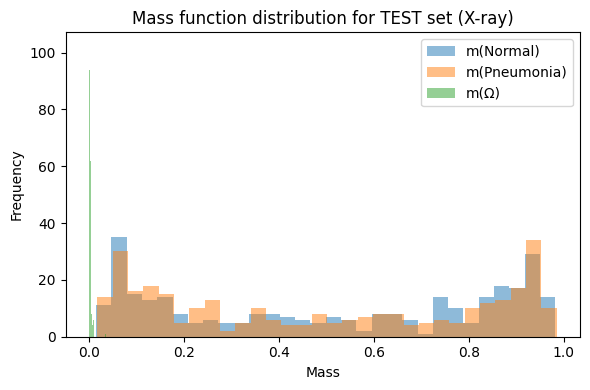

In [71]:
# Display mass function distribution
plt.figure(figsize=(6, 4))
plt.hist(df_m_test_xray["m_Normal"], bins=30, alpha=0.5, label="m(Normal)")
plt.hist(df_m_test_xray["m_Pneumonia"],     bins=30, alpha=0.5, label="m(Pneumonia)")
plt.hist(df_m_test_xray["m_Omega"],     bins=30, alpha=0.5, label="m(Ω)")
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.title("Mass function distribution for TEST set (X-ray)")
plt.legend()
plt.tight_layout()
plt.show()

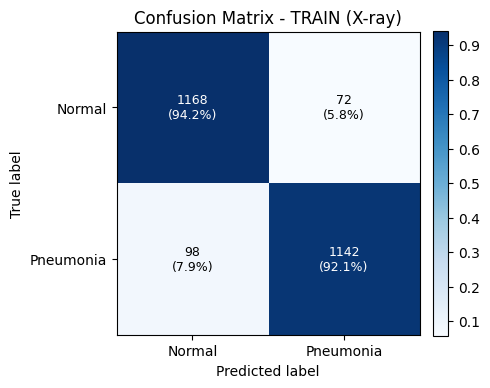

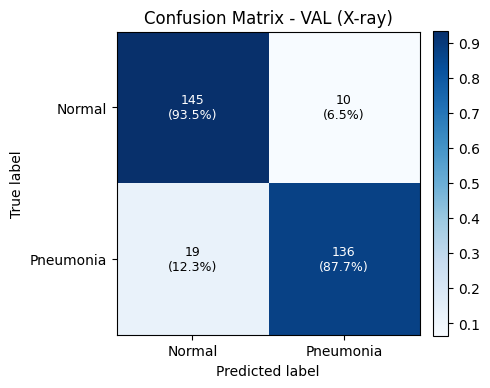

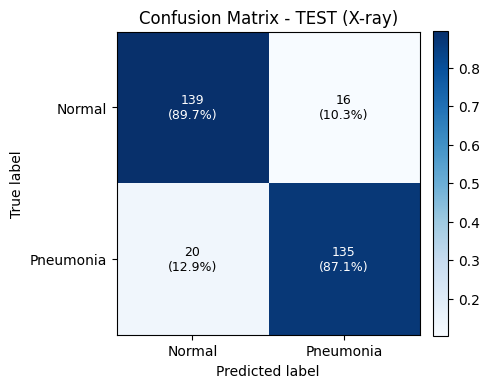

In [72]:
# Display confussion matrix
class_names = ["Normal", "Pneumonia"]

def plot_conf_matrix(y_true_enn, y_pred_enn, class_names, title="Confusion Matrix"):
    """
    y_true_enn, y_pred_enn : label 1..M (sesuai ENN)
    """
    # change it to 0/1
    y_true = y_true_enn - 1
    y_pred = y_pred_enn - 1

    cm = confusion_matrix(y_true, y_pred)
    cm_norm = cm.astype(np.float64) / cm.sum(axis=1, keepdims=True)

    fig, ax = plt.subplots(figsize=(5, 5))
    im = ax.imshow(cm_norm, interpolation="nearest", cmap="Blues")

    ax.set_title(title)
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)
    ax.set_xlabel("Predicted label")
    ax.set_ylabel("True label")

    thresh = cm_norm.max() / 2.0
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            text = f"{cm[i, j]}\n({cm_norm[i, j]*100:.1f}%)"
            ax.text(
                j, i, text,
                ha="center", va="center",
                color="white" if cm_norm[i, j] > thresh else "black",
                fontsize=9,
            )

    fig.colorbar(im, ax=ax, fraction=0.046, pad=0.04)
    plt.tight_layout()
    plt.show()

# TRAIN
plot_conf_matrix(
    y_true_enn=y_train_enn_xray,
    y_pred_enn=eval_train_xray["ypred"],
    class_names=class_names,
    title="Confusion Matrix - TRAIN (X-ray)"
)

# VAL
plot_conf_matrix(
    y_true_enn=y_val_enn_xray,
    y_pred_enn=eval_val_xray["ypred"],
    class_names=class_names,
    title="Confusion Matrix - VAL (X-ray)"
)

# TEST
plot_conf_matrix(
    y_true_enn=y_test_enn_xray,
    y_pred_enn=eval_test_xray["ypred"],
    class_names=class_names,
    title="Confusion Matrix - TEST (X-ray)"
)

In [73]:
# Save the parameter model ENN post training
enn_model_dir_xray = Path("/kaggle/working/enn_model/xray")
enn_model_dir_xray.mkdir(parents=True, exist_ok=True)

np.savez(enn_model_dir_xray / "ENN_sub1_trained_params_xray.npz",
         W=param_trained_xray["W"],
         gamma=param_trained_xray["gamma"],
         beta=param_trained_xray["beta"],
         alpha=param_trained_xray["alpha"])

### CT

In [74]:
# Load data
enn_features_dir = Path("/kaggle/working/features_enn/ct")

train_enn_ct_npz = enn_features_dir / "sub1_train_ct_ENN.npz"
val_enn_ct_npz   = enn_features_dir / "sub1_val_ct_ENN.npz"
test_enn_ct_npz  = enn_features_dir / "sub1_test_ct_ENN.npz"
# sub2_enn_ct_npz  = enn_features_dir / "sub2_ct_ENN.npz" # akan dipakai ketika contextual discounting

for p in [train_enn_ct_npz, val_enn_ct_npz, test_enn_ct_npz]:
    assert p.exists(), f"File is not found: {p}"

In [75]:
def load_enn_npz(path):
    data = np.load(path)
    X = data["X_ct"].astype(np.float64)
    y_enn = data["y_enn"].astype(int)
    y_orig = data["y_orig"].astype(int)
    return X, y_enn, y_orig

X_train_ct, y_train_enn_ct, y_train_orig_ct = load_enn_npz(train_enn_ct_npz)
X_val_ct,   y_val_enn_ct,   y_val_orig_ct   = load_enn_npz(val_enn_ct_npz)
X_test_ct,  y_test_enn_ct,  y_test_orig_ct  = load_enn_npz(test_enn_ct_npz)
# X_sub2_ct,  y_sub2_enn_ct,  y_sub2_orig_ct  = load_enn_npz(sub2_enn_ct_npz)

print("Shapes before ENN:")
print("Train:", X_train_ct.shape, "Label ENN:", y_train_enn_ct.shape)
print("Val  :", X_val_ct.shape,   "Label ENN:", y_val_enn_ct.shape)
print("Test :", X_test_ct.shape,  "Label ENN:", y_test_enn_ct.shape)
# print("Sub2 :", X_sub2_ct.shape,  "Label ENN:", y_sub2_enn_ct.shape)

Shapes before ENN:
Train: (2480, 512) Label ENN: (2480,)
Val  : (310, 512) Label ENN: (310,)
Test : (310, 512) Label ENN: (310,)


In [76]:
# Set hyperparameter ENN

nproto_per_class_ct = 5              # number of prototypes per class
use_nproto_per_class_ct = True       # True -> nproto_per_class applies per class
crisp_prototypes_ct = False          # False -> beta is slightly “softer”

# CHANGE THIS: Increase lambda to preserve more ignorance mass
lam = None   # Try values: 1.0, 2.0, or even 5.0 (higher = more uncertainty)
mu  = 1e-3                          # regulation for alpha
optimProto = True                   # optimization of prototype position W

options = {
    "maxiter": 250,                 # Iteration
    "eta": 0.1,                     # initial step
    "gain_min": 1e-5,               # stopping threshold
    "disp": 50,                     # iteration print frequency
}

In [77]:
# Initialization of ENN parameters (proDSinit)
print("\nInitialization of ENN parameters")
param0 = proDSinit(
    x=X_train_ct,
    y=y_train_enn_ct,
    nproto=nproto_per_class_ct,
    nprotoPerClass=use_nproto_per_class_ct,
    crisp=crisp_prototypes_ct,
    random_state=42,
)

print("W Size  :", param0["W"].shape)
print("Beta Size:", param0["beta"].shape)
print("Gamma Size:", param0["gamma"].shape)
print("Alpha Size:", param0["alpha"].shape)


Initialization of ENN parameters
W Size  : (10, 512)
Beta Size: (10, 2)
Gamma Size: (10,)
Alpha Size: (10,)


In [78]:
# Training ENN (proDSfit)
print("\nTraining ENN CT")
fit_result_ct = proDSfit(
    x=X_train_ct,
    y=y_train_enn_ct,
    param=param0,
    lam=lam,
    mu=mu,
    optimProto=optimProto,
    options=options,
)

param_trained_ct = fit_result_ct["param"]  # Use distinct variable name
final_cost_ct    = fit_result_ct["cost"]
train_err_fit_ct = fit_result_ct["err"]

print("\nTraining Result CT")
print(f"Final Cost        : {final_cost_ct:.6f}")
print(f"Training error   : {train_err_fit_ct:.4f}")
print(f"Training accuracy: {1.0 - train_err_fit_ct:.4f}")


Training ENN CT
iter 1, E=0.203805, gain=10.000000
iter 51, E=0.166899, gain=0.099759
iter 101, E=0.116329, gain=0.012354
iter 151, E=0.075332, gain=0.005335
iter 201, E=0.063951, gain=0.002566
iter 251, E=0.058160, gain=0.001099

Training Result CT
Final Cost        : 0.058160
Training error   : 0.0290
Training accuracy: 0.9710


In [79]:
# Performace Evaluation for ENN in Train / Val / Test
class_names = ["Normal", "Pneumonia"]

eval_train_ct = eval_split("TRAIN", X_train_ct, y_train_enn_ct, param_trained_ct, label_names=class_names)
eval_val_ct   = eval_split("VAL",   X_val_ct,   y_val_enn_ct,   param_trained_ct, label_names=class_names)
eval_test_ct  = eval_split("TEST",  X_test_ct,  y_test_enn_ct,  param_trained_ct, label_names=class_names)


=== TRAIN ===
Total sample          : 2480
Error rate            : 0.0290
Accuracy              : 0.9710
Total EPL             : 1052.1269
Average EPL per sample: 3.3940

Classification report:
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97      1240
   Pneumonia       0.95      0.99      0.97      1240

    accuracy                           0.97      2480
   macro avg       0.97      0.97      0.97      2480
weighted avg       0.97      0.97      0.97      2480


=== VAL ===
Total sample          : 310
Error rate            : 0.0258
Accuracy              : 0.9742
Total EPL             : 130.2794
Average EPL per sample: 0.4203

Classification report:
              precision    recall  f1-score   support

      Normal       0.99      0.95      0.97       155
   Pneumonia       0.96      0.99      0.97       155

    accuracy                           0.97       310
   macro avg       0.97      0.97      0.97       310
weighted avg   

In [80]:
# Display sample mass function
m_test_ct = eval_test_ct["m"]  # shape (N, nclass+1) = (N, 3) for 2 class + Ω

df_m_test_ct = pd.DataFrame(
    m_test_ct,
    columns=["m_Normal", "m_Pneumonia", "m_Omega"]
)

print("The first 20 mass function TEST (CT):")
print(df_m_test_ct.head(20))

The first 20 mass function TEST (CT):
    m_Normal  m_Pneumonia   m_Omega
0   0.841898     0.155771  0.002330
1   0.180422     0.816915  0.002663
2   0.627957     0.371048  0.000994
3   0.913223     0.084877  0.001899
4   0.940463     0.057649  0.001888
5   0.961681     0.037627  0.000692
6   0.223709     0.775528  0.000762
7   0.124057     0.874392  0.001551
8   0.051905     0.946696  0.001399
9   0.337768     0.653009  0.009223
10  0.028114     0.971557  0.000329
11  0.294233     0.704911  0.000857
12  0.801153     0.197656  0.001191
13  0.971335     0.028172  0.000493
14  0.467369     0.531503  0.001128
15  0.890122     0.106031  0.003847
16  0.940300     0.058803  0.000897
17  0.301571     0.697653  0.000777
18  0.957804     0.041218  0.000978
19  0.936003     0.063292  0.000705


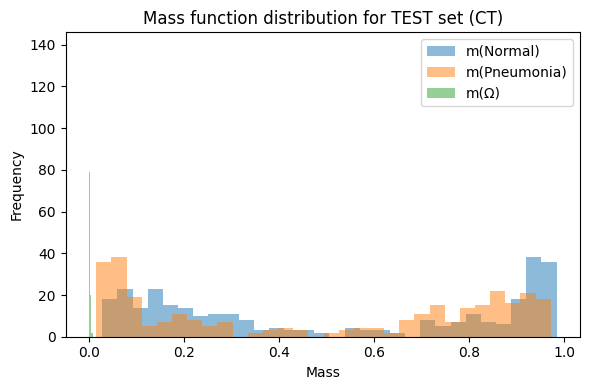

In [81]:
# Menampilkan distribusi mass function
plt.figure(figsize=(6, 4))
plt.hist(df_m_test_ct["m_Normal"], bins=30, alpha=0.5, label="m(Normal)")
plt.hist(df_m_test_ct["m_Pneumonia"],     bins=30, alpha=0.5, label="m(Pneumonia)")
plt.hist(df_m_test_ct["m_Omega"],     bins=30, alpha=0.5, label="m(Ω)")
plt.xlabel("Mass")
plt.ylabel("Frequency")
plt.title("Mass function distribution for TEST set (CT)")
plt.legend()
plt.tight_layout()
plt.show()

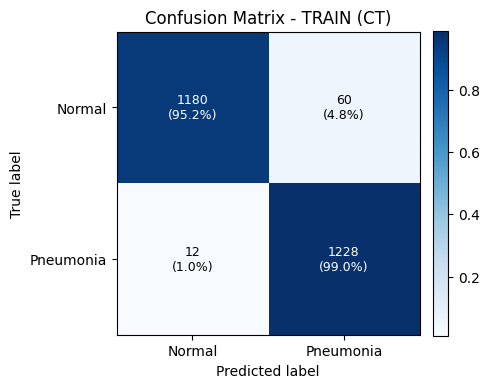

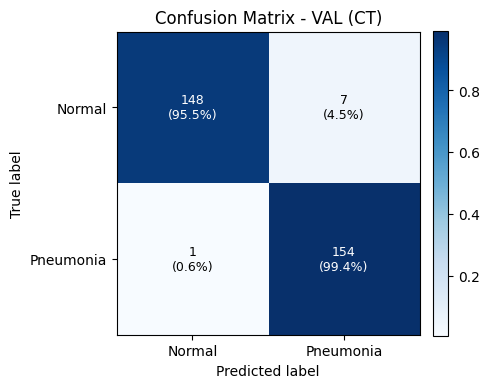

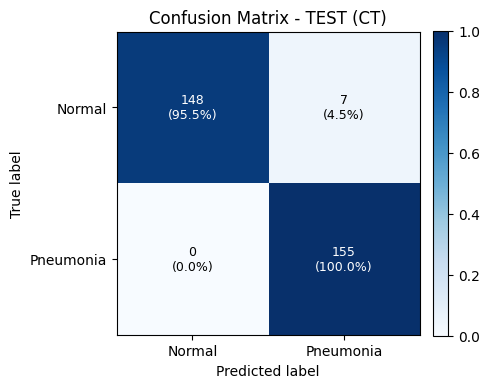

In [82]:
# Display confussion matrix
class_names = ["Normal", "Pneumonia"]

# TRAIN
plot_conf_matrix(
    y_true_enn=y_train_enn_ct,
    y_pred_enn=eval_train_ct["ypred"],
    class_names=class_names,
    title="Confusion Matrix - TRAIN (CT)"
)

# VAL
plot_conf_matrix(
    y_true_enn=y_val_enn_ct,
    y_pred_enn=eval_val_ct["ypred"],
    class_names=class_names,
    title="Confusion Matrix - VAL (CT)"
)

# TEST
plot_conf_matrix(
    y_true_enn=y_test_enn_ct,
    y_pred_enn=eval_test_ct["ypred"],
    class_names=class_names,
    title="Confusion Matrix - TEST (CT)"
)

In [83]:
# Save the parameter model ENN post training
enn_model_dir_ct = Path("/kaggle/working/enn_model/ct")
enn_model_dir_ct.mkdir(parents=True, exist_ok=True)

np.savez(enn_model_dir_ct / "ENN_sub1_trained_params_ct.npz",
         W=param_trained_ct["W"],
         gamma=param_trained_ct["gamma"],
         beta=param_trained_ct["beta"],
         alpha=param_trained_ct["alpha"])

# DEMPSTERSUM

## Support Function

In [84]:
def mtoq(m):
    m = np.array(m, dtype=float)
    lm = len(m)
    n = int(np.log2(lm))

    if 2**n != lm:
        raise ValueError("Input length must be a power of 2.")

    q = m.copy()
    for step in range(n):   # loop dari 0 sampai n-1
        block_size = 2**step
        for j in range(0, lm, 2*block_size):
            for k in range(block_size):
                q[j + k] += q[j + block_size + k]

    return q

In [85]:
def qtom(q):
    q = np.asfortranarray(np.array(q, dtype=float))  # pastikan column-major
    lm = q.size
    natoms = int(round(np.log2(lm)))
    if 2**natoms != lm:
        raise ValueError("length of input vector not OK: should be a power of 2")

    for step in range(1, natoms + 1):
        i124 = 2**(step - 1)
        i842 = 2**(natoms + 1 - step)
        i421 = 2**(natoms - step)
        q = np.reshape(q, (i124, i842), order='F')        # seperti dim(q) di R
        odds = np.arange(0, 2*i421, 2)                    # 0,2,4,... (kolom ganjil R)
        q[:, odds] = q[:, odds] - q[:, odds + 1]          # q[, odd] <- q[, odd] - q[, odd+1]
        q = np.reshape(q, (lm,), order='F')               # flatten kolom
    return q

In [86]:
def mnormalized(m):
    m = np.array(m, dtype=float)
    if m[0] == 1:
        print("ACCIDENT in mnormalized: you try to normalize a categorical mass on the empty set")
        return m
    else:
        m = m / (1 - m[0])
        m[0] = 0
        return m

In [87]:
def csum(m1, m2):
    q1 = mtoq(m1)
    q2 = mtoq(m2)
    return qtom(q1 * q2)

In [88]:
def dempstersum(m1, m2):
    return mnormalized(csum(m1, m2))

## Call Function

In [89]:
# Debug: Check shapes
print("eval_test_xray['m'] shape:", eval_test_xray["m"].shape)
print("eval_test_ct['m'] shape:", eval_test_ct["m"].shape)

# Get mass functions from ENN evaluation results
m_xray_raw = eval_test_xray["m"]  # Shape: (N, 3) - [m(Normal), m(Pneumonia), m(Ω)]
m_ct_raw = eval_test_ct["m"]      # Shape: (N, 3) - [m(Normal), m(Pneumonia), m(Ω)]

# Convert to full representation. mtoM processes the batch correctly.
M_xray = mtoM(m_xray_raw)  # Shape: (N, 4)
M_ct = mtoM(m_ct_raw)      # Shape: (N, 4)

print("M_xray shape after mtoM:", M_xray.shape)
print("M_ct shape after mtoM:", M_ct.shape)

M_combined = np.array([
    dempstersum(M_xray[i, :], M_ct[i, :])
    for i in range(M_xray.shape[0])
])

print("M_combined shape:", M_combined.shape)

eval_test_xray['m'] shape: (310, 3)
eval_test_ct['m'] shape: (310, 3)
M_xray shape after mtoM: (310, 4)
M_ct shape after mtoM: (310, 4)
M_combined shape: (310, 4)


# REWARD

## REWARD FUNCTION MTOSETSD

In [90]:
def btobel(b):
    """
    Konversi implicability function menjadi belief function.

    Parameters
    ----------
    b : array-like
        Vektor implicability function, panjang harus merupakan pangkat dua (2^n).

    Returns
    -------
    bel : ndarray
        Vektor belief function.
    """
    b = np.array(b, dtype=float)

    # Kasus error: categorical mass pada himpunan kosong
    if b[0] == 1:
        raise ValueError("ACCIDENT in btobel: you try to normalize a categorical mass on the empty set")

    lm = len(b)
    natoms = round(np.log2(lm))

    # Pastikan panjang b adalah pangkat dua
    if 2**natoms != lm:
        raise ValueError("ACCIDENT in btobel: length of input vector not OK: should be a power of 2")

    # Kurangi semua elemen dengan kontribusi himpunan kosong (b[0])
    bel = b - b[0]

    return bel


In [91]:
def pltob(pl, debug=False):
    """
    Mengubah plausibility function (pl) menjadi implicability function (b).

    Parameters
    ----------
    pl : array_like
        Vektor plausibility function. Panjang harus 2^n (n = jumlah kelas).
    debug : bool, optional
        Jika True, akan menampilkan detail perhitungan.

    Returns
    -------
    b : np.ndarray
        Vektor implicability function dengan panjang sama seperti pl.
    """
    pl = np.asarray(pl, dtype=float).ravel()
    lm = pl.size
    natoms = int(round(np.log2(lm)))

    if 2 ** natoms != lm:
        raise ValueError(
            f"Panjang input pl = {lm}, tidak valid. "
            f"Harus berupa pangkat 2 (2^n)."
        )

    # implicability: b(A) = 1 - pl(complement(A))
    b = 1.0 - np.flip(pl)

    if debug:
        print("pl:", pl)
        print("fliplr(pl):", np.flip(pl))
        print("implicability b:", b)

    return b

In [92]:
def btopl(b):
    b = np.array(b, dtype=float)
    lm = len(b)
    natoms = round(np.log2(lm))
    if 2**natoms == lm:
        b = b[lm-1] - np.flip(b)   # np.flip = fliplr untuk 1D
        b[0] = 0
        return b
    else:
        raise ValueError("ACCIDENT in btopl: length of input vector not OK: should be a power of 2")


In [93]:
def pltobel(pl):
    """
    Convert plausibility function to belief function.

    Parameters
    ----------
    pl : list or numpy array
        Plausibility function (length = 2^n).

    Returns
    -------
    bel : numpy array
        Belief function (length = 2^n).

    References
    ----------
    P. Smets and R. Kennes. The Transferable Belief Model.
    Artificial Intelligence, 66:191–243, 1994.
    """
    return btobel(pltob(pl))

In [94]:
def mtob(m):
    m = np.array(m, dtype=float)
    lm = len(m)
    n = int(np.log2(lm))

    if 2**n != lm:
        raise ValueError("Input length must be a power of 2.")

    b = m.copy()
    for i in range(n):
        step = 2 ** i
        for j in range(0, lm, 2 * step):
            for k in range(step):
                b[j + step + k] += b[j + k]

    return b

In [95]:
def mtobel(m):
    """
    Konversi mass function menjadi belief function.

    Parameters
    ----------
    m : array-like
        Mass function dengan 2^n elemen (n = jumlah atom/frame).

    Returns
    -------
    bel : ndarray
        Belief function hasil konversi.
    """
    return btobel(mtob(m))

In [96]:
def mtopl(m):
    """
    Mengubah mass function (m) menjadi plausibility function (pl).

    Parameters
    ----------
    m : array-like of shape (2^n,)
        Mass function (dengan 2^n elemen, n = jumlah kelas)

    Returns
    -------
    pl : ndarray of shape (2^n,)
        Plausibility function
    """
    return btopl(mtob(m))

In [97]:
def mtosetsd(m):
    """
    Compute a set of partial decisions using the strong dominance criterion (interval dominance).

    Parameters
    ----------
    m : list or np.ndarray
        Mass function (length must be a power of 2).

    Returns
    -------
    out_vec : np.ndarray
        Vector of 0-1 values:
        1 if singleton i is non-dominated under the strong dominance criterion,
        0 otherwise.
    """
    m = np.array(m, dtype=float)
    lm = len(m)
    natoms = int(round(np.log2(lm)))

    if 2**natoms != lm:
        raise ValueError("Input length must be a power of 2.")

    bel = mtobel(m)
    pl = mtopl(m)

    out_vec = np.ones(natoms, dtype=int)

    for i in range(natoms):
        for j in range(natoms):
            if i != j:
                # posisi singleton ke-i ada di index 2^i
                if bel[2**j] >= pl[2**i]:
                    out_vec[i] = 0
                    break

    return out_vec

In [98]:
def reward_U65(x):
    """
    Compute performance using utility-discounted accuracy U65

    Args:
        x: DataFrame with columns:
           - Column 0: prediction_set (string like "1", "12", "123")
           - Column 1: (not used)
           - Column 2: true_class (string)

    Returns:
        sum of rewards
    """
    sum_rew = 0
    for j in range(len(x)):
        s = len(str(x.iloc[j, 0]))
        if str(x.iloc[j, 2]) in str(x.iloc[j, 0]):
            sum_rew = sum_rew + (1.6/s - (0.6/(s**2)))
    return sum_rew

In [99]:
# Function for changing format
def prediction_set_to_string(pred_set):
    """
    Convert binary prediction set (from mtosetsd) to string format for reward_U65.

    Parameters
    ----------
    pred_set : array-like
        Binary vector from mtosetsd where 1 = non-dominated class, 0 = dominated class

    Returns
    -------
    str
        String representation like "1", "12", "123", etc.
    """
    classes = []
    for i, val in enumerate(pred_set):
        if val == 1:
            classes.append(str(i + 1))  # 1-based class labels
    return "".join(classes) if classes else "12"  # default to "12" if empty (fallback)

In [100]:
def pltocf(pl):
    """
    Menghitung contour function (cf) dari plausibility function (pl).

    Parameters
    ----------
    pl : array-like, shape (2^n,)
        Vektor plausibility function

    Returns
    -------
    cf : ndarray, shape (n,)
        Contour function (plausibility pada singleton)
    """
    pl = np.array(pl, dtype=float)
    lm = len(pl)
    natoms = round(np.log2(lm))

    # cek apakah panjang pl valid
    if 2**natoms != lm:
        raise ValueError("ACCIDENT in pltocf: length of input vector not OK: should be a power of 2")

    cf = np.zeros(natoms)
    for i in range(natoms):
        cf[i] = pl[2**i]   # ambil plausibility singleton

    return cf

In [101]:
def tvtotm(tv, nclass):
    """
    Return the truth given as a matrix from the truth given as a vector

    Args:
        tv: true class of each object given as a vector: tv[i]=class of object i
        nclass: number of classes (some being possibly not in the vector)

    Returns:
        tm: true class of each object given as a matrix such that:
            tm[i,j] = 0 iff object i is not of class j
            tm[i,j] = 1 iff object i is of class j

    Example:
        tv = [1, 2, 1, 3]
        tvtotm(tv, 3)
        # => return
        #      [[1, 0, 0],
        #       [0, 1, 0],
        #       [1, 0, 0],
        #       [0, 0, 1]]

    Authors: S. Mutmainah, S. Hachour, F. Pichon, D. Mercier
    """
    # nclass should be taken from number of class in a whole data
    # nclass = len(set(tv))  # alternative: number of unique classes in tv
    nobj = len(tv)  # Number of objects
    tm = np.zeros((nobj, nclass), dtype=int)

    for i in range(nobj):
        tm[i, tv[i] - 1] = 1  # Subtract 1 for 0-based indexing in Python

    return tm

In [102]:
def epl(cf, y_true_r):
    nclass = int(np.max(y_true_r))
    truth = tvtotm(y_true_r, nclass)
    return float(np.sum((cf - truth) ** 2))

## REWARD USAGE MTOSETSD

### XRAY


In [103]:
# Convert X-ray raw mass functions to full mass representation
M_xray_individual = mtoM(eval_test_xray["m"])

# Total EPL X-ray
xray_total_epl, xray_avg_epl = finding_epl(M_xray_individual, y_test_enn_xray)

# Apply mtosetsd to each X-ray mass function to get prediction sets
prediction_sets_xray = []
for i in range(M_xray_individual.shape[0]):
    pred_set_binary = mtosetsd(M_xray_individual[i, :])
    pred_set_str = prediction_set_to_string(pred_set_binary)
    prediction_sets_xray.append(pred_set_str)

# True labels for X-ray (y_test_orig_xray already contains 0/1)
true_labels_str_xray = np.where(y_test_orig_xray == 0, "1", "2").astype(str)

# Create DataFrame for U65 reward calculation
df_for_u65_xray = pd.DataFrame({
    0: prediction_sets_xray,
    1: [''] * len(prediction_sets_xray),
    2: true_labels_str_xray
})

# Calculate U65 reward for X-ray
total_u65_reward_xray = reward_U65(df_for_u65_xray)
print(f"\nTotal U65 reward for X-ray model: {total_u65_reward_xray:.4f}")
print(f"Average U65 reward per X-ray sample: {total_u65_reward_xray / len(df_for_u65_xray):.4f}")
print(f"Total EPL: {xray_total_epl:.4f}")
print(f"Average EPL per sample: {xray_avg_epl:.4f}")


Total U65 reward for X-ray model: 274.0000
Average U65 reward per X-ray sample: 0.8839
Total EPL: 140.9375
Average EPL per sample: 0.4546


### CT-Scan

In [104]:
# Convert CT-scan raw mass functions to full mass representation
M_ct_individual = mtoM(eval_test_ct["m"])

# Total EPL CT-Scan
ct_total_epl, ct_avg_epl = finding_epl(M_ct_individual, y_test_enn_xray)

# Apply mtosetsd to each CT-scan mass function to get prediction sets
prediction_sets_ct = []
for i in range(M_ct_individual.shape[0]):
    pred_set_binary = mtosetsd(M_ct_individual[i, :])
    pred_set_str = prediction_set_to_string(pred_set_binary)
    prediction_sets_ct.append(pred_set_str)

# True labels for CT-scan (y_test_orig_ct already contains 0/1)
true_labels_str_ct = np.where(y_test_orig_ct == 0, "1", "2").astype(str)

# Create DataFrame for U65 reward calculation
df_for_u65_ct = pd.DataFrame({
    0: prediction_sets_ct,
    1: [''] * len(prediction_sets_ct),
    2: true_labels_str_ct
})

# Calculate U65 reward for CT-scan
total_u65_reward_ct = reward_U65(df_for_u65_ct)
print(f"\nTotal U65 reward for CT-scan model: {total_u65_reward_ct:.4f}")
print(f"Average U65 reward per CT-scan sample: {total_u65_reward_ct / len(df_for_u65_ct):.4f}")
print(f"Total EPL: {ct_total_epl:.4f}")
print(f"Average EPL per sample: {ct_avg_epl:.4f}")


Total U65 reward for CT-scan model: 303.0000
Average U65 reward per CT-scan sample: 0.9774
Total EPL: 134.2812
Average EPL per sample: 0.4332


### FUSION

In [105]:
# Total EPL CT-Scan
fusion_total_epl, fusion_avg_epl = finding_epl(M_combined, y_test_enn_xray)

# Generate prediction sets using mtosetsd (strong dominance criterion)
prediction_sets = []
for i in range(M_combined.shape[0]):
    # Apply mtosetsd to get binary prediction set [0,1] or [1,0] or [1,1]
    pred_set_binary = mtosetsd(M_combined[i, :])
    pred_set_str = prediction_set_to_string(pred_set_binary)
    prediction_sets.append(pred_set_str)

print("Sample prediction sets:", prediction_sets[:10])

# y_test_orig_xray contains 0 (Normal) or 1 (Pneumonia)
# Convert to "1" (Normal) or "2" (Pneumonia) for reward_U65
true_labels_str = np.where(y_test_orig_xray == 0, "1", "2").astype(str)

df_for_u65 = pd.DataFrame({
    0: prediction_sets,
    1: [''] * len(prediction_sets),  # dummy column (not used)
    2: true_labels_str
})

# Calculate U65 reward
total_u65_reward = reward_U65(df_for_u65)

print(f"Total U65 reward for combined model: {total_u65_reward:.4f}")
print(f"Average U65 reward per sample: {total_u65_reward / len(df_for_u65):.4f}")
print(f"Total EPL: {fusion_total_epl:.4f}")
print(f"Average EPL per sample: {fusion_avg_epl:.4f}")

Sample prediction sets: ['1', '2', '2', '1', '1', '1', '2', '2', '2', '2']
Total U65 reward for combined model: 305.0000
Average U65 reward per sample: 0.9839
Total EPL: 144.9500
Average EPL per sample: 0.4676


# K-Fold Cross-Evaluation

In [106]:
# Preparing for K-Fold
X_xray_for_kfold = np.concatenate([X_train_xray, X_val_xray, X_test_xray])
X_ct_for_kfold = np.concatenate([X_train_ct, X_val_ct, X_test_ct])
y_enn_for_kfold = np.concatenate([y_train_enn_xray, y_val_enn_xray, y_test_enn_xray])
print("X-Ray shapes before splitting after feature extraction: ",len(X_xray_for_kfold))
print("CT-Scan shapes before splitting after feature extraction: ",len(X_ct_for_kfold))
print("y_enn_for_kfold shapes before splitting after feature extraction: ",len(y_enn_for_kfold))

X-Ray shapes before splitting after feature extraction:  3100
CT-Scan shapes before splitting after feature extraction:  3100
y_enn_for_kfold shapes before splitting after feature extraction:  3100


In [107]:
# n_splits = 10
# random_state = 42

# skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

# fold_results = []

# for fold, (train_idx, val_idx) in enumerate(skf.split(X_xray_for_kfold, y_enn_for_kfold), 1):
#     print(f"\n{'='*60}")
#     print(f"FOLD {fold}/{n_splits} - FUSION (X-ray + CT-scan)")
#     print(f"{'='*60}")

#     X_xray_train_fold, X_xray_val_fold = X_xray_for_kfold[train_idx], X_xray_for_kfold[val_idx]
#     X_ct_train_fold, X_ct_val_fold = X_ct_for_kfold[train_idx], X_ct_for_kfold[val_idx]
#     y_enn_train_fold, y_enn_val_fold = y_enn_for_kfold[train_idx], y_enn_for_kfold[val_idx]

#     print(f"\n{'='*60}")
#     print("\nSubsets Size for X-Ray:")
#     print("Train:", len(X_xray_train_fold))
#     print("Val  :", len(X_xray_val_fold))

#     print(f"\n{'='*60}")
#     print("\nSubset size for CT-Scan:")
#     print("Train:", len(X_ct_train_fold))
#     print("Val  :", len(X_ct_val_fold))

#     options = {
#         "maxiter": 250,                 # Iteration
#         "eta": 0.1,                     # initial step
#         "gain_min": 1e-5,               # stopping threshold
#         "disp": 50,                     # iteration print frequency
#     }

#     # Initialization of ENN parameters (proDSinit)
#     print("\nInitialization of ENN parameters")
#     param0 = proDSinit(
#         x=X_xray_train_fold,
#         y=y_enn_train_fold,
#         nproto=5,
#         nprotoPerClass=True,
#         crisp=False,
#         random_state=42,
#     )

#     print("W Size  :", param0["W"].shape)
#     print("Beta Size:", param0["beta"].shape)
#     print("Gamma Size:", param0["gamma"].shape)
#     print("Alpha Size:", param0["alpha"].shape)

#     # Training ENN (proDSfit)
#     print("\nTraining ENN X-ray")
#     fit_result_xray = proDSfit(
#         x=X_xray_train_fold,
#         y=y_enn_train_fold,
#         param=param0,
#         lam=None,
#         mu=1e-3,
#         optimProto=True,
#         options=options,
#     )

#     param_trained_xray = fit_result_xray["param"]
#     final_cost_xray    = fit_result_xray["cost"]
#     train_err_fit_xray = fit_result_xray["err"]

#     # print("\nTraining Result X-ray")
#     # print(f"Final Cost       : {final_cost_xray:.6f}")
#     # print(f"Training error   : {train_err_fit_xray:.4f}")
#     # print(f"Training accuracy: {1.0 - train_err_fit_xray:.4f}")

#     # Initialization of ENN parameters (proDSinit)
#     print("\nInitialization of ENN parameters")
#     param0 = proDSinit(
#         x=X_ct_train_fold,
#         y=y_enn_train_fold,
#         nproto=5,
#         nprotoPerClass=True,
#         crisp=False,
#         random_state=42,
#     )

#     # print("W Size  :", param0["W"].shape)
#     # print("Beta Size:", param0["beta"].shape)
#     # print("Gamma Size:", param0["gamma"].shape)
#     # print("Alpha Size:", param0["alpha"].shape)

#     # Training ENN (proDSfit)
#     print("\nTraining ENN CT")
#     fit_result_ct = proDSfit(
#         x=X_ct_train_fold,
#         y=y_enn_train_fold,
#         param=param0,
#         lam=None,
#         mu=1e-3,
#         optimProto=True,
#         options=options,
#     )

#     param_trained_ct = fit_result_ct["param"]  # Use distinct variable name
#     final_cost_ct    = fit_result_ct["cost"]
#     train_err_fit_ct = fit_result_ct["err"]

#     # print("\nTraining Result CT")
#     # print(f"Final Cost        : {final_cost_ct:.6f}")
#     # print(f"Training error   : {train_err_fit_ct:.4f}")
#     # print(f"Training accuracy: {1.0 - train_err_fit_ct:.4f}")

#     xray_val_fold = proDSval(X_xray_val_fold, param_trained_xray, y_enn_val_fold)
#     m_xray      = xray_val_fold["m"]          # (N, nclass+1)
#     ypred_xray  = xray_val_fold["ypred"]      # 1..M
#     err_xray    = xray_val_fold["err"]
#     acc_xray    = 1.0 - err_xray

#     M_xray_fold = mtoM(m_xray)
#     fold_xray_total_epl, fold_xray_avg_epl = finding_epl(M_xray_fold, y_enn_val_fold)

#     print(f"\n=== Val ===")
#     print(f"Total sample          : {len(y_enn_val_fold)}")
#     print(f"Error rate            : {err_xray:.4f}")
#     print(f"Accuracy              : {acc_xray:.4f}")
#     print(f"Total EPL X-Ray Val   : {fold_xray_total_epl:.4f}")
#     print(f"Average EPL per sample: {fold_xray_avg_epl:.4f}")

#     ct_val_fold = proDSval(X_ct_val_fold, param_trained_ct, y_enn_val_fold)
#     m_ct      = ct_val_fold["m"]          # (N, nclass+1)
#     ypred_ct  = ct_val_fold["ypred"]      # 1..M
#     err_ct    = ct_val_fold["err"]
#     acc_ct    = 1.0 - err_ct

#     M_ct_fold = mtoM(m_ct)
#     fold_ct_total_epl, fold_ct_avg_epl = finding_epl(M_ct_fold, y_enn_val_fold)

#     print(f"\n=== Val ===")
#     print(f"Total sample          : {len(y_enn_val_fold)}")
#     print(f"Error rate            : {err_xray:.4f}")
#     print(f"Accuracy              : {acc_xray:.4f}")
#     print(f"Total EPL CT-Scan Val : {fold_xray_total_epl:.4f}")
#     print(f"Average EPL per sample: {fold_xray_avg_epl:.4f}")

#     # Get mass functions from ENN evaluation results
#     m_fold_xray_raw = xray_val_fold["m"]
#     m_fold_ct_raw = ct_val_fold["m"]

#     # Convert to full representation. mtoM processes the batch correctly.
#     M_xray_fold = mtoM(m_fold_xray_raw)  # Shape: (N, 4)
#     M_ct_fold = mtoM(m_fold_ct_raw)      # Shape: (N, 4)

#     print("M_xray each fold shape after mtoM:", M_xray_fold.shape)
#     print("M_ct each fold shape after mtoM:", M_ct_fold.shape)

#     M_combined_fold = np.array([
#         dempstersum(M_xray_fold[i, :], M_ct_fold[i, :])
#         for i in range(M_xray_fold.shape[0])
#     ])

#     print("M_combined shape:", M_combined_fold.shape)

#     # Convert X-ray raw mass functions to full mass representation
#     M_xray_fold_individual = mtoM(eval_test_xray["m"])

#     # Total EPL X-ray
#     xray_fold_total_epl, xray_fold_avg_epl = finding_epl(M_xray_fold_individual, y_test_enn_xray)

#     # Apply mtosetsd to each X-ray mass function to get prediction sets
#     prediction_sets_xray = []
#     for i in range(M_xray_fold_individual.shape[0]):
#         pred_set_binary = mtosetsd(M_xray_fold_individual[i, :])
#         pred_set_str = prediction_set_to_string(pred_set_binary)
#         prediction_sets_xray.append(pred_set_str)

#     # True labels for X-ray (y_test_orig_xray already contains 0/1)
#     true_labels_str_xray = np.where(y_test_orig_xray == 0, "1", "2").astype(str)

#     # Create DataFrame for U65 reward calculation
#     df_for_u65_xray_per_fold = pd.DataFrame({
#         0: prediction_sets_xray,
#         1: [''] * len(prediction_sets_xray),
#         2: true_labels_str_xray
#     })

#     # Calculate U65 reward for X-ray
#     total_u65_reward_xray_per_fold = reward_U65(df_for_u65_xray_per_fold)
#     print(f"\nTotal U65 reward for X-ray model: {total_u65_reward_xray_per_fold:.4f}")
#     print(f"Average U65 reward per X-ray sample: {total_u65_reward_xray_per_fold / len(df_for_u65_xray_per_fold):.4f}")
#     print(f"Total EPL per Fold: {xray_fold_total_epl:.4f}")
#     print(f"Average EPL per Fold: {xray_fold_avg_epl:.4f}")

#     # Convert CT-scan raw mass functions to full mass representation
#     M_ct_fold_individual = mtoM(eval_test_ct["m"])

#     # Total EPL CT-Scan
#     ct_fold_total_epl, ct_fold_avg_epl = finding_epl(M_ct_fold_individual, y_test_enn_xray)

#     # Apply mtosetsd to each CT-scan mass function to get prediction sets
#     prediction_sets_ct = []
#     for i in range(M_ct_fold_individual.shape[0]):
#         pred_set_binary = mtosetsd(M_ct_fold_individual[i, :])
#         pred_set_str = prediction_set_to_string(pred_set_binary)
#         prediction_sets_ct.append(pred_set_str)

#     # True labels for CT-scan (y_test_orig_ct already contains 0/1)
#     true_labels_str_ct = np.where(y_test_orig_ct == 0, "1", "2").astype(str)

#     # Create DataFrame for U65 reward calculation
#     df_for_u65_ct_per_fold = pd.DataFrame({
#         0: prediction_sets_ct,
#         1: [''] * len(prediction_sets_ct),
#         2: true_labels_str_ct
#     })

#     # Calculate U65 reward for CT-scan
#     total_u65_reward_ct_per_fold = reward_U65(df_for_u65_ct_per_fold)
#     print(f"\nTotal U65 reward for CT-scan model: {total_u65_reward_ct_per_fold:.4f}")
#     print(f"Average U65 reward per CT-scan sample: {total_u65_reward_ct_per_fold / len(df_for_u65_ct_per_fold):.4f}")
#     print(f"Total EPL per Fold: {ct_fold_total_epl:.4f}")
#     print(f"Average EPL per Fold: {ct_fold_avg_epl:.4f}")

#     # Total EPL Fold
#     fusion_fold_total_epl, fusion_fold_avg_epl = finding_epl(M_combined_fold, y_test_enn_xray)

#     # Generate prediction sets using mtosetsd (strong dominance criterion)
#     prediction_sets = []
#     for i in range(M_combined_fold.shape[0]):
#         # Apply mtosetsd to get binary prediction set [0,1] or [1,0] or [1,1]
#         pred_set_binary = mtosetsd(M_combined_fold[i, :])
#         pred_set_str = prediction_set_to_string(pred_set_binary)
#         prediction_sets.append(pred_set_str)

#     print("Sample prediction sets:", prediction_sets[:10])

#     # y_test_orig_xray contains 0 (Normal) or 1 (Pneumonia)
#     # Convert to "1" (Normal) or "2" (Pneumonia) for reward_U65
#     true_labels_str = np.where(y_test_orig_xray == 0, "1", "2").astype(str)

#     df_for_u65_fold_fusion = pd.DataFrame({
#         0: prediction_sets,
#         1: [''] * len(prediction_sets),  # dummy column (not used)
#         2: true_labels_str
#     })

#     # Calculate U65 reward
#     total_u65_reward_fold_fusion = reward_U65(df_for_u65_fold_fusion)

#     print(f"\nTotal U65 reward for fusion model: {total_u65_reward_fold_fusion:.4f}")
#     print(f"Average U65 reward fusion per fold: {total_u65_reward_fold_fusion / len(df_for_u65_fold_fusion):.4f}")
#     print(f"Total EPL fusion per fold: {fusion_fold_total_epl:.4f}")
#     print(f"Average EPL fusion per fold: {fusion_fold_avg_epl:.4f}")

In [108]:
n_splits = 10
random_state = 42

skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

fold_results = []

for fold, (train_idx, val_idx) in enumerate(skf.split(X_xray_for_kfold, y_enn_for_kfold), 1):
    print(f"\n{'='*60}")
    print(f"FOLD {fold}/{n_splits} - FUSION (X-ray + CT-scan)")
    print(f"{'='*60}")

    X_xray_train_fold, X_xray_val_fold = X_xray_for_kfold[train_idx], X_xray_for_kfold[val_idx]
    X_ct_train_fold, X_ct_val_fold = X_ct_for_kfold[train_idx], X_ct_for_kfold[val_idx]
    y_enn_train_fold, y_enn_val_fold = y_enn_for_kfold[train_idx], y_enn_for_kfold[val_idx]

    print(f"\nSubsets Size for X-Ray:")
    print("Train:", len(X_xray_train_fold))
    print("Val  :", len(X_xray_val_fold))

    print(f"\nSubset size for CT-Scan:")
    print("Train:", len(X_ct_train_fold))
    print("Val  :", len(X_ct_val_fold))

    options = {
        "maxiter": 250,
        "eta": 0.1,
        "gain_min": 1e-5,
        "disp": 50,
    }

    # ========== X-RAY ENN ==========
    print("\nInitialization of ENN parameters (X-ray)")
    param0_xray = proDSinit(
        x=X_xray_train_fold,
        y=y_enn_train_fold,
        nproto=5,
        nprotoPerClass=True,
        crisp=False,
        random_state=42,
    )

    print("\nTraining ENN X-ray")
    fit_result_xray = proDSfit(
        x=X_xray_train_fold,
        y=y_enn_train_fold,
        param=param0_xray,
        lam=None,
        mu=1e-3,
        optimProto=True,
        options=options,
    )
    param_trained_xray = fit_result_xray["param"]

    # ========== CT-SCAN ENN ==========
    print("\nInitialization of ENN parameters (CT)")
    param0_ct = proDSinit(
        x=X_ct_train_fold,
        y=y_enn_train_fold,
        nproto=5,
        nprotoPerClass=True,
        crisp=False,
        random_state=42,
    )

    print("\nTraining ENN CT")
    fit_result_ct = proDSfit(
        x=X_ct_train_fold,
        y=y_enn_train_fold,
        param=param0_ct,
        lam=None,
        mu=1e-3,
        optimProto=True,
        options=options,
    )
    param_trained_ct = fit_result_ct["param"]

    # ========== VALIDATION ==========
    # X-ray validation
    xray_val_result = proDSval(X_xray_val_fold, param_trained_xray, y_enn_val_fold)
    m_xray = xray_val_result["m"]
    # err_xray = xray_val_result["err"]
    # acc_xray = 1.0 - err_xray

    M_xray_fold = mtoM(m_xray)
    xray_total_epl, xray_avg_epl = finding_epl(M_xray_fold, y_enn_val_fold)

    # print(f"\n=== X-Ray ===")
    # print(f"Total sample          : {len(y_enn_val_fold)}")
    # # print(f"Error rate            : {err_xray:.4f}")
    # # print(f"Accuracy              : {acc_xray:.4f}")
    # print(f"Total EPL             : {xray_total_epl:.4f}")
    # print(f"Average EPL           : {xray_avg_epl:.4f}")

    # CT-scan validation
    ct_val_result = proDSval(X_ct_val_fold, param_trained_ct, y_enn_val_fold)
    m_ct = ct_val_result["m"]
    # err_ct = ct_val_result["err"]rai
    # acc_ct = 1.0 - err_ct

    M_ct_fold = mtoM(m_ct)
    ct_total_epl, ct_avg_epl = finding_epl(M_ct_fold, y_enn_val_fold)

    # print(f"\n=== CT-Scan ===")
    # print(f"Total sample          : {len(y_enn_val_fold)}")
    # # print(f"Error rate            : {err_ct:.4f}")  # FIXED
    # # print(f"Accuracy              : {acc_ct:.4f}")  # FIXED
    # print(f"Total EPL             : {ct_total_epl:.4f}")  # FIXED
    # print(f"Average EPL           : {ct_avg_epl:.4f}")  # FIXED

    # ========== FUSION (Dempster's Rule) ==========
    M_combined_fold = np.array([
        dempstersum(M_xray_fold[i, :], M_ct_fold[i, :])
        for i in range(M_xray_fold.shape[0])
    ])

    fusion_total_epl, fusion_avg_epl = finding_epl(M_combined_fold, y_enn_val_fold)

    # ========== U65 REWARD (using FOLD validation data) ==========
    # Convert fold labels (1-based) to string format for reward_U65
    true_labels_str_fold = np.where(y_enn_val_fold == 1, "1", "2").astype(str)

    # X-ray U65
    prediction_sets_xray = []
    for i in range(M_xray_fold.shape[0]):
        pred_set_binary = mtosetsd(M_xray_fold[i, :])
        pred_set_str = prediction_set_to_string(pred_set_binary)
        prediction_sets_xray.append(pred_set_str)

    df_u65_xray = pd.DataFrame({
        0: prediction_sets_xray,
        1: [''] * len(prediction_sets_xray),
        2: true_labels_str_fold  # FIXED: use fold labels
    })
    u65_xray = reward_U65(df_u65_xray)

    # print(f"\n=== X-Ray U65 ===")
    print(f"\n=== X-Ray ===")
    print(f"Total sample          : {len(y_enn_val_fold)}")
    # print(f"Error rate            : {err_xray:.4f}")
    # print(f"Accuracy              : {acc_xray:.4f}")
    print(f"Total EPL             : {xray_total_epl:.4f}")
    print(f"Average EPL           : {xray_avg_epl:.4f}")
    print(f"Total U65 reward      : {u65_xray:.4f}")
    print(f"Average U65 per sample: {u65_xray / len(df_u65_xray):.4f}")

    # CT-scan U65
    prediction_sets_ct = []
    for i in range(M_ct_fold.shape[0]):
        pred_set_binary = mtosetsd(M_ct_fold[i, :])
        pred_set_str = prediction_set_to_string(pred_set_binary)
        prediction_sets_ct.append(pred_set_str)

    df_u65_ct = pd.DataFrame({
        0: prediction_sets_ct,
        1: [''] * len(prediction_sets_ct),
        2: true_labels_str_fold  # FIXED: use fold labels
    })
    u65_ct = reward_U65(df_u65_ct)

    # print(f"\n=== CT-Scan U65 ===")
    print(f"\n=== CT-Scan ===")
    print(f"Total sample          : {len(y_enn_val_fold)}")
    # print(f"Error rate            : {err_ct:.4f}")  # FIXED
    # print(f"Accuracy              : {acc_ct:.4f}")  # FIXED
    print(f"Total EPL             : {ct_total_epl:.4f}")  # FIXED
    print(f"Average EPL           : {ct_avg_epl:.4f}")  # FIXED
    print(f"Total U65 reward      : {u65_ct:.4f}")
    print(f"Average U65 per sample: {u65_ct / len(df_u65_ct):.4f}")

    # Fusion U65
    prediction_sets_fusion = []
    for i in range(M_combined_fold.shape[0]):
        pred_set_binary = mtosetsd(M_combined_fold[i, :])
        pred_set_str = prediction_set_to_string(pred_set_binary)
        prediction_sets_fusion.append(pred_set_str)

    df_u65_fusion = pd.DataFrame({
        0: prediction_sets_fusion,
        1: [''] * len(prediction_sets_fusion),
        2: true_labels_str_fold  # FIXED: use fold labels
    })
    u65_fusion = reward_U65(df_u65_fusion)

    print(f"\n=== Fusion U65 ===")
    print(f"Total sample          : {len(y_enn_val_fold)}")
    print(f"Total EPL fusion      : {fusion_total_epl:.4f}")
    print(f"Average EPL fusion    : {fusion_avg_epl:.4f}")
    print(f"Total U65 reward      : {u65_fusion:.4f}")
    print(f"Average U65 per sample: {u65_fusion / len(df_u65_fusion):.4f}")


    # Store fold results
    fold_results.append({
        'fold': fold,
        # 'acc_xray': acc_xray,
        # 'acc_ct': acc_ct,
        'epl_xray_total': xray_total_epl,
        'epl_ct_total': ct_total_epl,
        'epl_fusion_total': fusion_total_epl,
        'epl_xray_avg': xray_avg_epl,
        'epl_ct_avg': ct_avg_epl,
        'epl_fusion': fusion_avg_epl,
        'u65_xray': u65_xray / len(df_u65_xray),
        'u65_ct': u65_ct / len(df_u65_ct),
        'u65_fusion': u65_fusion / len(df_u65_fusion),
    })


FOLD 1/10 - FUSION (X-ray + CT-scan)

Subsets Size for X-Ray:
Train: 2790
Val  : 310

Subset size for CT-Scan:
Train: 2790
Val  : 310

Initialization of ENN parameters (X-ray)

Training ENN X-ray
iter 1, E=0.212595, gain=10.000000
iter 51, E=0.164063, gain=0.087226
iter 101, E=0.092379, gain=0.009016
iter 151, E=0.083061, gain=0.001555
iter 201, E=0.077693, gain=0.001331
iter 251, E=0.074944, gain=0.000483

Initialization of ENN parameters (CT)

Training ENN CT
iter 1, E=0.203791, gain=10.000000
iter 51, E=0.158999, gain=0.092094
iter 101, E=0.084889, gain=0.013378
iter 151, E=0.064379, gain=0.002804
iter 201, E=0.058574, gain=0.001180
iter 251, E=0.055644, gain=0.000503

=== X-Ray ===
Total sample          : 310
Total EPL             : 134.5277
Average EPL           : 0.4340
Total U65 reward      : 276.3000
Average U65 per sample: 0.8913

=== CT-Scan ===
Total sample          : 310
Total EPL             : 130.3972
Average EPL           : 0.4206
Total U65 reward      : 301.0000
Averag

In [113]:
# Summary across all folds
print(f"\n{'='*60}")
print("K-FOLD CROSS-VALIDATION SUMMARY")
print(f"{'='*60}")
print(f"{'Fold':<8} {'X-ray EPL':<15} {'CT-Scan EPL':<15} {'Fusion EPL':<15}")
print("-"*60)
total_epl_xray = [result['epl_xray_total'] for result in fold_results]
total_epl_ct = [result['epl_ct_total'] for result in fold_results]
total_epl_fusion = [result['epl_fusion_total'] for result in fold_results]

mean_epl_xray = np.mean(total_epl_xray)
mean_epl_ct = np.mean(total_epl_ct)
mean_epl_fusion = np.mean(total_epl_fusion)

std_epl_xray = np.std(total_epl_xray)
std_epl_ct = np.std(total_epl_ct)
std_epl_fusion = np.std(total_epl_fusion)

for i in range(len(fold_results)):
  print(f"{i+1:<9} {total_epl_xray[i]:<15.3f} {total_epl_ct[i]:<15.3f} {total_epl_fusion[i]:<15.3f}")

print("-"*60)
print(f"{'Mean':<9} {mean_epl_xray:<15.3f} {mean_epl_ct:<15.3f} {mean_epl_fusion:<15.3f}")
print(f"{'Std':<9} {std_epl_xray:<15.4f} {std_epl_ct:<15.4f} {std_epl_fusion:<15.4f}")
print("-"*60)
print(f"X-ray EPL Mean    : {mean_epl_xray:.3f} \u00b1 {std_epl_xray:.3f}")
print(f"CT-Scan EPL Mean  : {mean_epl_ct:.3f} \u00b1 {std_epl_ct:.3f}")
print(f"Fusion EPL Mean   : {mean_epl_fusion:.3f} \u00b1 {std_epl_fusion:.3f}")


K-FOLD CROSS-VALIDATION SUMMARY
Fold     X-ray EPL       CT-Scan EPL     Fusion EPL     
------------------------------------------------------------
1         134.528         130.397         140.896        
2         135.214         128.574         144.361        
3         136.847         129.838         143.776        
4         135.326         130.537         141.856        
5         137.820         133.264         147.125        
6         135.262         131.819         142.046        
7         136.084         136.220         147.767        
8         133.424         131.452         145.174        
9         140.549         133.246         149.360        
10        130.994         134.777         142.532        
------------------------------------------------------------
Mean      135.605         132.012         144.489        
Std       2.4218          2.2388          2.6843         
------------------------------------------------------------
X-ray EPL Mean    : 135.605 ± 2

In [116]:
# Summary across all folds
print(f"\n{'='*70}")
print("K-FOLD CROSS-VALIDATION SUMMARY")
print(f"{'='*70}")
print(f"{'Fold':<8} {'X-ray U65 Reward':<20} {'CT-Scan U65 Reward':<20} {'Fusion U65 Reward':<20}")
print("-"*70)
total_u65_xray = [result['u65_xray'] for result in fold_results]
total_u65_ct = [result['u65_ct'] for result in fold_results]
total_u65_fusion = [result['u65_fusion'] for result in fold_results]

mean_u65_xray = np.mean(total_u65_xray)
mean_u65_ct = np.mean(total_u65_ct)
mean_u65_fusion = np.mean(total_u65_fusion)

std_u65_xray = np.std(total_u65_xray)
std_u65_ct = np.std(total_u65_ct)
std_u65_fusion = np.std(total_u65_fusion)

for i in range(len(fold_results)):
  print(f"{i+1:<9} {total_u65_xray[i]:<20.4f} {total_u65_ct[i]:<20.4f} {total_u65_fusion[i]:<20.4f}")

print("-"*70)
print(f"{'Mean':<9} {mean_u65_xray:<20.4f} {mean_u65_ct:<20.4f} {mean_u65_fusion:<20.4f}")
print(f"{'Std':<9} {std_u65_xray:<20.4f} {std_u65_ct:<20.4f} {std_u65_fusion:<20.4f}")
print("-"*70)
print(f"X-ray U65 Mean    : {mean_u65_xray:.3f} \u00b1 {std_u65_xray:.3f}")
print(f"CT-Scan U65 Mean  : {mean_u65_ct:.3f} \u00b1 {std_u65_ct:.3f}")
print(f"Fusion U65 Mean   : {mean_u65_fusion:.3f} \u00b1 {std_u65_fusion:.3f}")


K-FOLD CROSS-VALIDATION SUMMARY
Fold     X-ray U65 Reward     CT-Scan U65 Reward   Fusion U65 Reward   
----------------------------------------------------------------------
1         0.8913               0.9710               0.9871              
2         0.9161               0.9742               0.9839              
3         0.9063               0.9710               0.9774              
4         0.9194               0.9710               0.9935              
5         0.9311               0.9806               0.9903              
6         0.9452               0.9613               0.9968              
7         0.9150               0.9839               0.9935              
8         0.9074               0.9548               0.9935              
9         0.9129               0.9742               0.9774              
10        0.9645               0.9613               0.9935              
----------------------------------------------------------------------
Mean      0.9209       